#                       Mexico's COVID19 Data description and Analisys


<img align="center" src="https://i.imgur.com/ywPyXHY.png">


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import joblib
import seaborn as sns
import calendar
from datetime import datetime, timedelta
from collections import OrderedDict
from IPython.display import clear_output
# Data helper modules
from Covid_suite import Covid
from constants import *

In [2]:
database = {'confirmed'   : 'Casos_Diarios_Estado_Nacional_Confirmados_20200726.csv',
            'suspicious'  : 'Casos_Diarios_Estado_Nacional_Sospechosos_20200726.csv',
            'negatives'   : 'Casos_Diarios_Estado_Nacional_Negativos_20200726.csv',
            'deaths'      : 'Casos_Diarios_Estado_Nacional_Defunciones_20200726.csv',
            'patients'    : '200726COVID19MEXICO.csv'}
# Update the database by writing the url of the csv's and running the update_data @classmethod:
# Data comes from: https://coronavirus.gob.mx/datos/#DownZCSV
Covid.update_data(database)

## Updated:  July / 26 / 2020

# 1.- Frequencies

## Confirmed, Deaths, Negative and Suspicious in Mexico

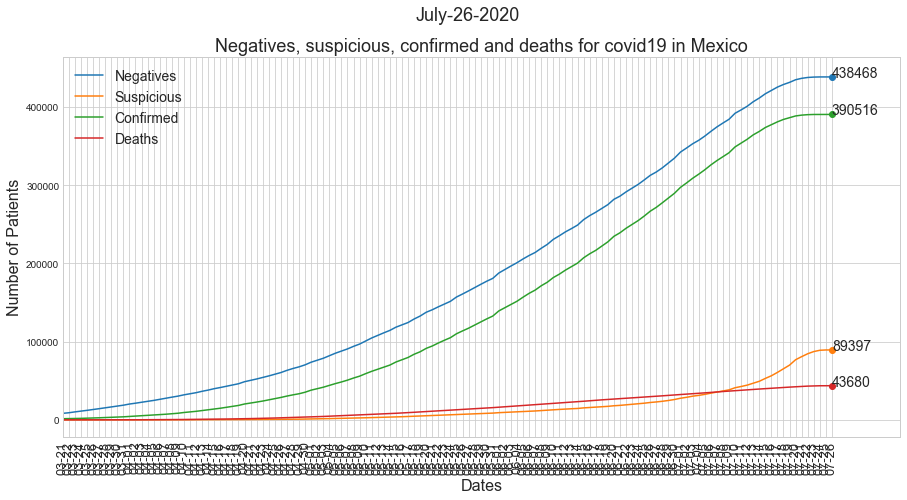

In [3]:
Covid.plot_cummulative(data  = [Covid('all').cummulative('negatives'),
                                Covid('all').cummulative('suspicious'),
                                Covid('all').cummulative('confirmed'),
                                Covid('all').cummulative('deaths')],
                                names = ['Negatives','Suspicious','Confirmed','Deaths'],
                                title = 'Negatives, suspicious, confirmed and deaths for covid19 in Mexico',
                                trim= 80)

## Confirmed and Suspicious by day in Mexico

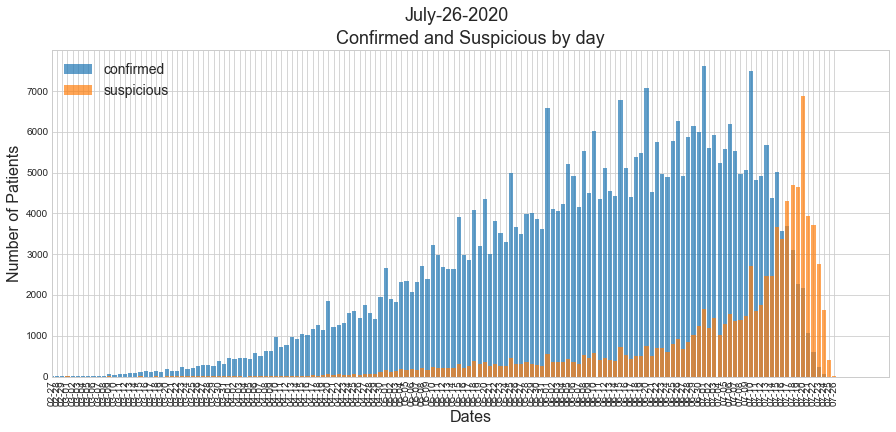

In [4]:
Covid.plot_discrete(data=[Covid('all').discrete('confirmed'),
                          Covid('all').discrete('suspicious')],
                    names=['confirmed','suspicious'],
                    title= 'Confirmed and Suspicious by day',
                    trim = 50)

## Deaths by day in Mexico

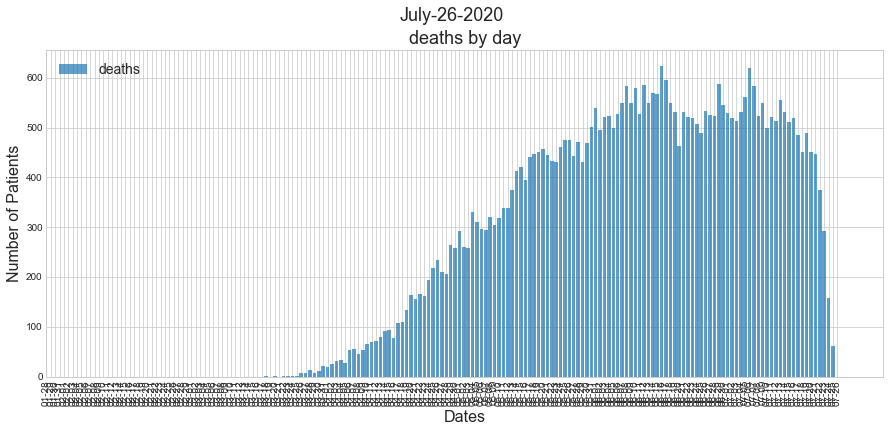

In [5]:
Covid.plot_discrete(data=Covid('all').discrete('deaths'),
                    names='deaths',
                    title= 'deaths by day',
                    trim = 20)

## Death Rate functions

In [6]:
def deathRate(state,trim):
    dates = pd.read_csv(database['deaths']).columns[3:]
    actives = Covid(state).actives(window=14)
    deaths = Covid(state).discrete('deaths')
    
    if len(actives)< len(deaths):
        deaths = deaths[len(deaths)-len(actives):]
        dates  = dates[len(dates)-len(actives):]
    else:
        actives = actives[len(actives)-len(deaths):]
        dates = dates[len(dates)-len(deaths):]
    
    plotDeathRate(state,dates,actives.actives.values,deaths,trim)
    
def deathRateByAge(state,start,end):
    deaths =  Covid(state).patients().deaths().age(start = start, end = end)
    alive =  Covid(state).patients().alive().age(start = start, end = end)
    deaths = len(deaths.data)
    alive = len(alive.data)
    try:
        result =  deaths/(alive/100)
    except:
        result = 0
    
    return result

def getageDeathRate(state):
    ageDeathRate = []
    for age in range(101):
        ageDeathRate.append(deathRateByAge(state,age,age))
    return ageDeathRate

def plotAgeDeathRate(state,trim):
    ageDeathRate = []
    for age in range(101):
        result = deathRateByAge(state,age,age)
        ageDeathRate.append(result)
        print(f'Done for age {age}: ',str(result) + ' %')
        clear_output(wait=True)
    
    plt.title('National Death Rate by Age', fontsize=25)
    plt.scatter([str(x) for x in range(101)],ageDeathRate,color='black')
    plt.xticks(fontsize=15,rotation=75)
    plt.yticks(fontsize=25)
    plt.ylabel('Death Rate', fontsize = 25)
    plt.xlabel('Age',fontsize=25)
    plt.xlim(trim,)
    plt.show()

## Nacional Death Rate by Date

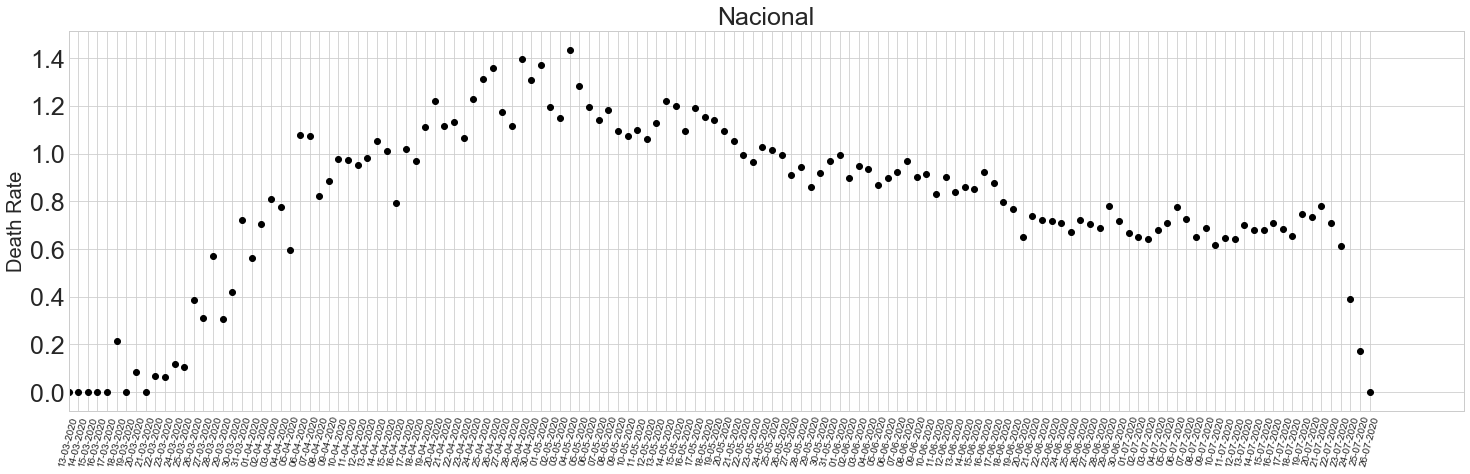

In [7]:
deathRate('Nacional',60)

## Death Rate by Age

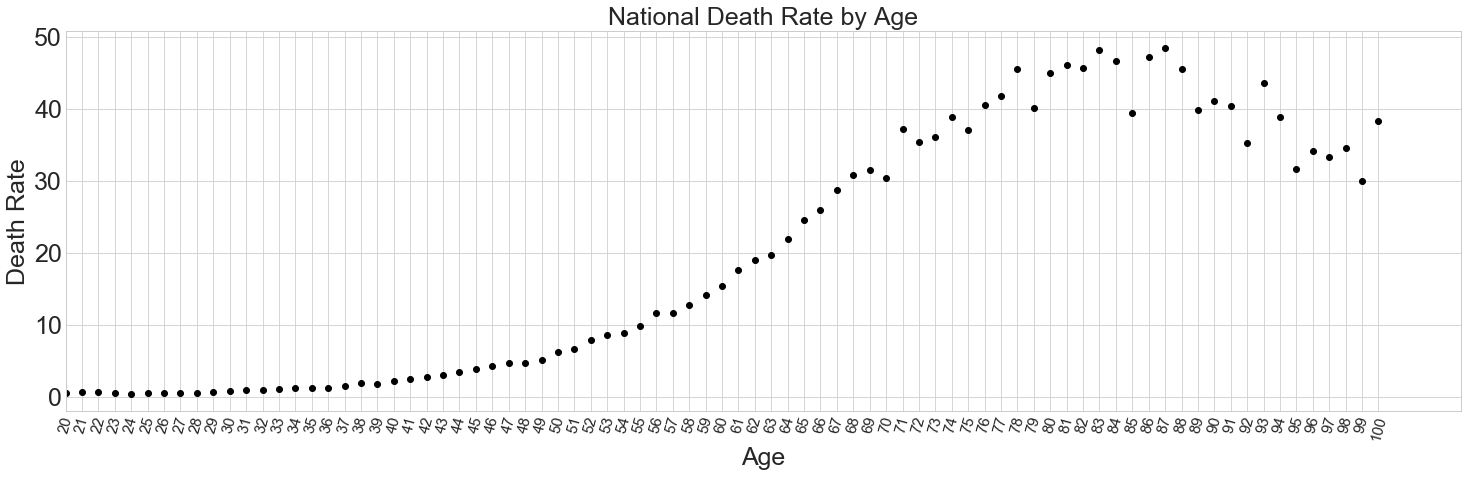

In [8]:
plotAgeDeathRate('Nacional',20)

## States with more Confirmed patients

In [9]:
Covid.plot_max_to_min('confirmed',n=16,title='States with more confirmed patients in Mexico',trim=60)

## States with more Deceased patients

In [10]:
Covid.plot_max_to_min('deaths',n=16,title='States with more deaths in Mexico',trim=60)

## Active Patients in Mexico

In [11]:
Covid.plot_actives(Covid('all').actives(window=14),
                   names='actives',
                   title='Active patients with covid19 in Mexico',
                   trim=60,
                   )

## States with more active patients

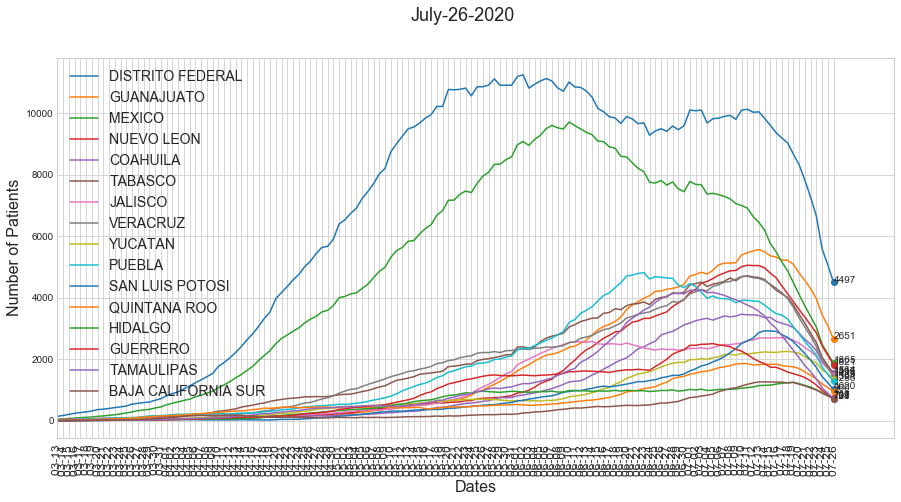

In [12]:
Covid.plot_max_to_min('actives',n=16,trim=60)

## States with less active patients

In [13]:
Covid.plot_max_to_min('actives', n=16, trim=60, max_to_min = False)

# 2.- Patients Data

### Institutions from where patients came from:

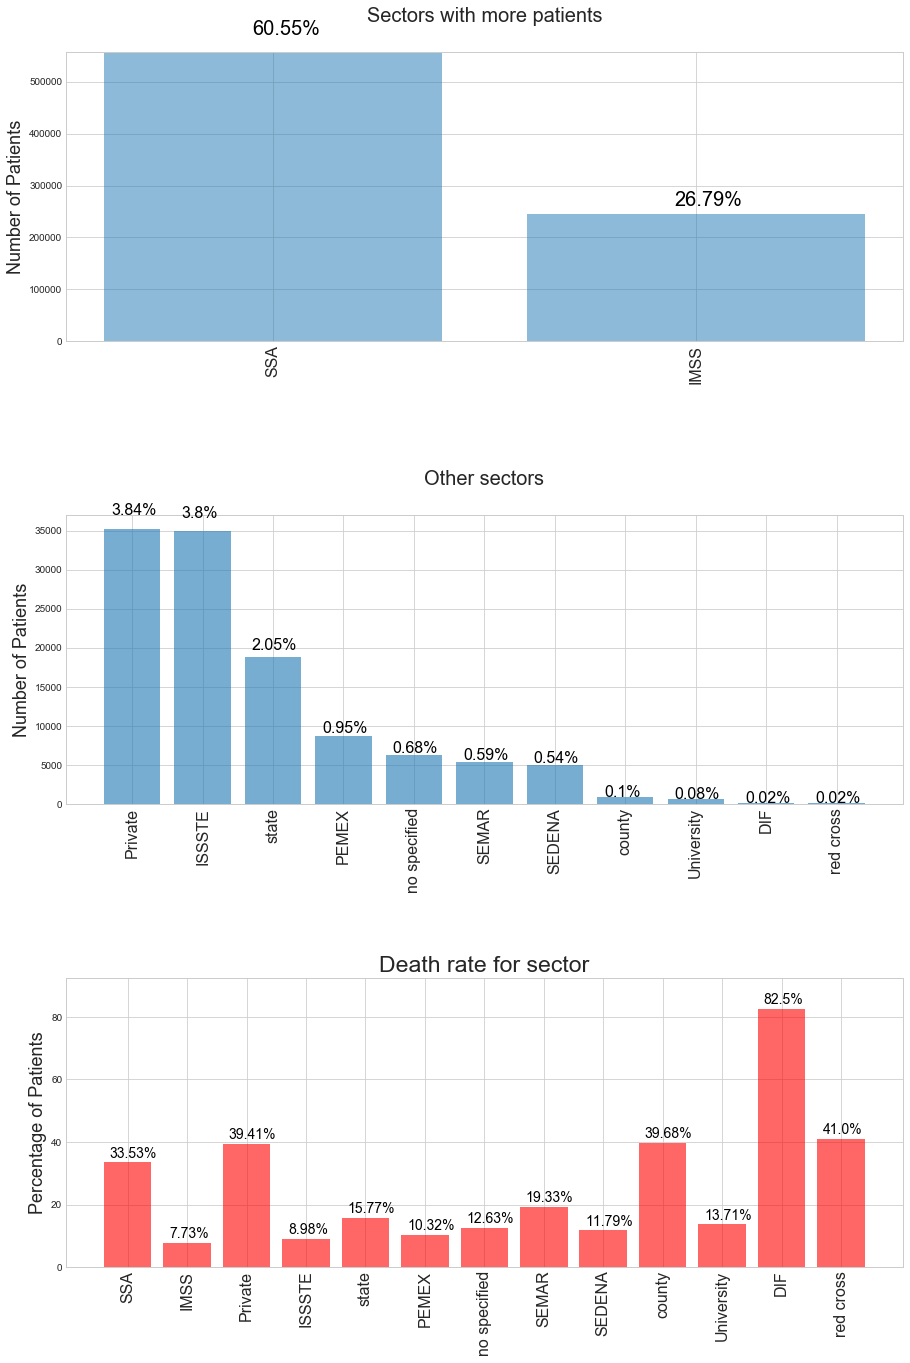

In [14]:
Covid('all').patients().sectors()

## Age for Infected population

In [15]:
ages = Covid('all').patients().infected().data.age.copy()

plt.close('all')
plt.rcParams["figure.figsize"] = (15,6)
ages.hist(bins=60,alpha=0.7)
plt.axvline(np.mean(ages), 0, 160000, label= f'Age mean {str(np.mean(ages))[:5]}',color= 'r',linewidth = 5)
plt.ylabel('Number of patients',fontsize=18)
plt.xlabel('age',fontsize=20)
plt.suptitle(calendar.month_name[int(Covid.database['patients'][2:4])]+'-'+Covid.database['patients'][4:6]+'-20'+Covid.database['patients'][:2], fontsize=18)
plt.legend(fontsize=18)
plt.show()

## Age for dead and alive patients

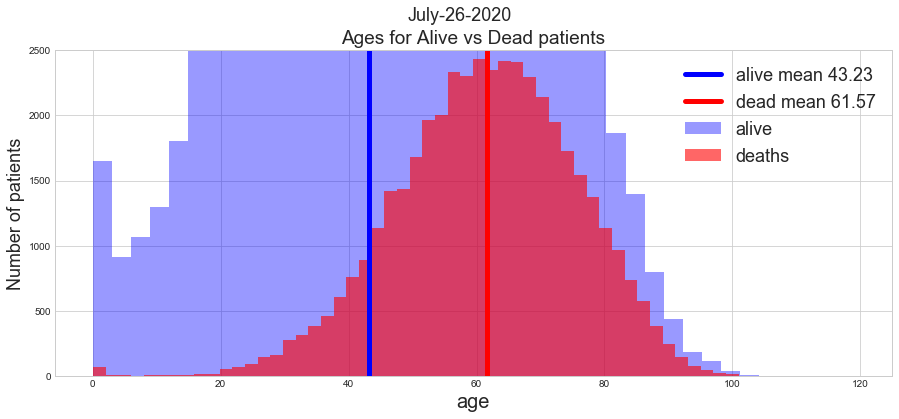

In [16]:
age_deaths = Covid('all').patients().infected().deaths().data.age.copy()
age_alive = Covid('all').patients().infected().alive().data.age.copy()

plt.close('all')
plt.rcParams["figure.figsize"] = (15,6)

age_alive.hist(bins = 40, alpha = 0.4, color = 'b',label='alive')
plt.axvline(np.mean(age_alive), 0, 160000, label= f'alive mean {str(np.mean(age_alive))[:5]}',color= 'b',linewidth = 5)

age_deaths.hist(bins = 52, alpha = 0.6, color = 'r',label='deaths')
plt.axvline(np.mean(age_deaths), 0, 160000, label= f'dead mean {str(np.mean(age_deaths))[:5]}',color= 'r',linewidth = 5)

plt.ylabel('Number of patients',fontsize=18)
plt.xlabel('age',fontsize=20)
plt.ylim(0,2500)
plt.title('Ages for Alive vs Dead patients', fontsize= 19)
plt.suptitle(calendar.month_name[int(Covid.database['patients'][2:4])]+'-'+Covid.database['patients'][4:6]+'-20'+Covid.database['patients'][:2], fontsize=18)
plt.legend(fontsize=18)
plt.show()

## Time from onset symptoms to death

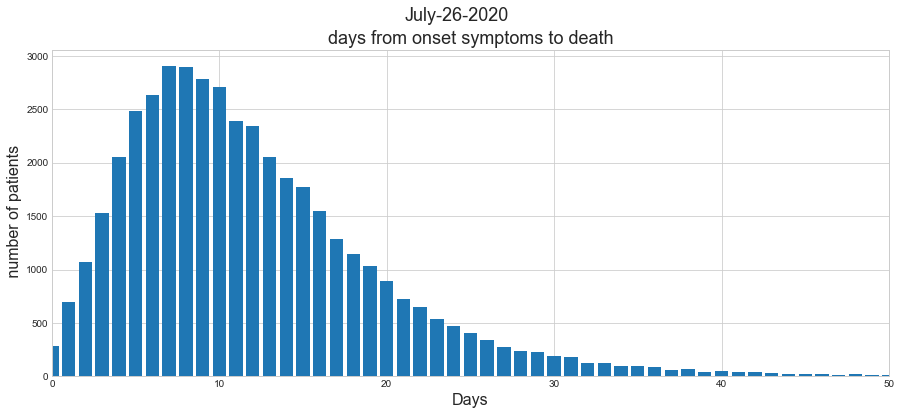

In [17]:
Covid('all').patients().plot_time_to_death()

## Sex frequency for infected patients

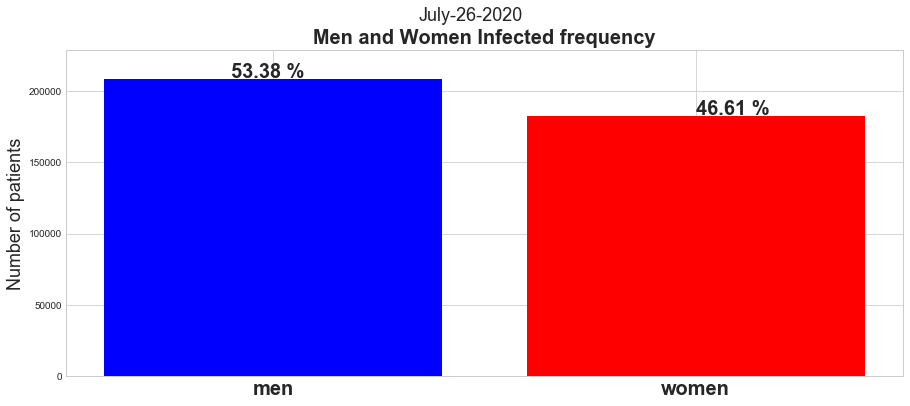

In [18]:
men  = Covid('all').patients().men().infected().data
women= Covid('all').patients().women().infected().data

plt.close('all')
plt.rcParams["figure.figsize"] = (15,6)

plt.bar(['men','women'],[len(men),len(women)],color=['b','r'])

plt.text(1,len(women)+1000,str((len(women)/(len(men)+len(women))*100))[:5]+' %',fontsize=20, fontweight='bold')
plt.text(-0.1,len(men)+1000,str((len(men)/(len(men)+len(women))*100))[:5]+' %',fontsize=20, fontweight='bold')

plt.ylabel('Number of patients', fontsize = 18)
plt.ylim(0,len(men)+20000)
plt.title('Men and Women Infected frequency', fontsize=20, fontweight='bold')
plt.suptitle(calendar.month_name[int(Covid.database['patients'][2:4])]+'-'+Covid.database['patients'][4:6]+'-20'+Covid.database['patients'][:2], fontsize=18)
plt.xticks(fontsize=20, fontweight='bold')
plt.show()

##  Ages for Infected Women and Men

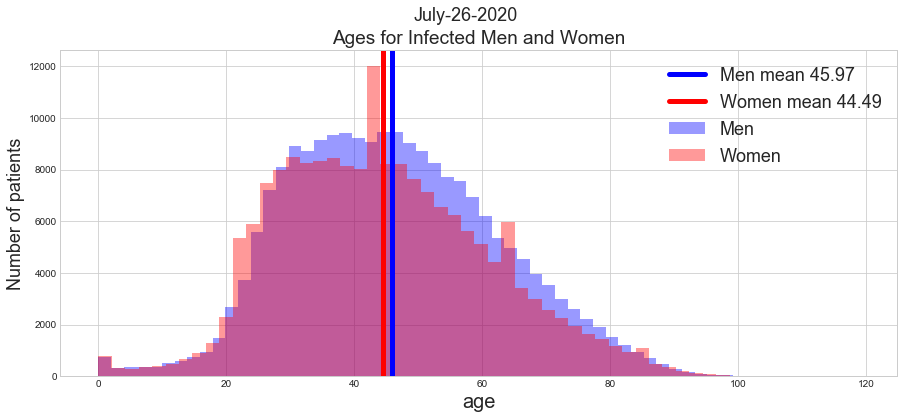

In [19]:
plt.close('all')
plt.rcParams["figure.figsize"] = (15,6)

men.age.hist(bins = 60, alpha = 0.4, color = 'b', label='Men')
plt.axvline(np.mean(men.age), 0, 160000, label= f'Men mean {str(np.mean(men.age))[:5]}',color = 'b', linewidth = 5)

women.age.hist(bins = 50, alpha = 0.4, color = 'r', label='Women')
plt.axvline(np.mean(women.age), 0, 160000, label= f'Women mean {str(np.mean(women.age))[:5]}', color= 'r', linewidth = 5)

plt.ylabel('Number of patients',fontsize=18)
plt.xlabel('age',fontsize=20)
# plt.ylim(0,1700)
plt.title('Ages for Infected Men and Women', fontsize= 19)
plt.legend(fontsize=18)
plt.suptitle(calendar.month_name[int(Covid.database['patients'][2:4])]+'-'+Covid.database['patients'][4:6]+'-20'+Covid.database['patients'][:2], fontsize=18)
plt.show()

## Proportions of deaths for men and women

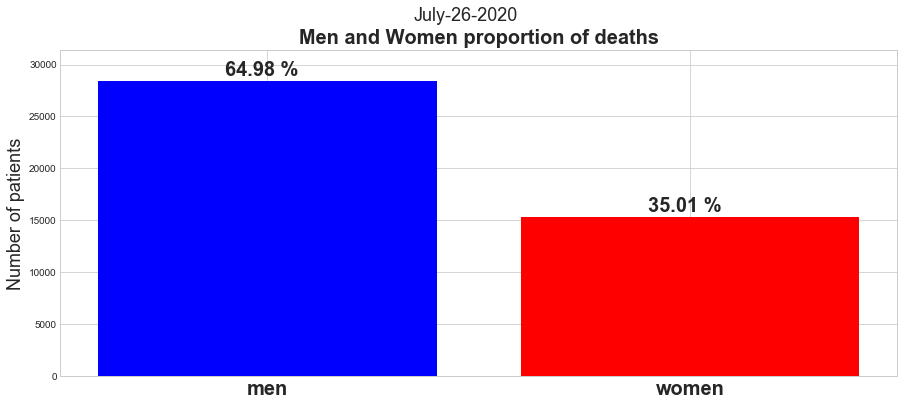

In [20]:
men_deaths = len(Covid('all').patients().men().deaths().infected().data)
women_deaths = len(Covid('all').patients().women().deaths().infected().data)

plt.close('all')
plt.rcParams["figure.figsize"] = (15,6)

plt.bar(['men','women'],[men_deaths,women_deaths], color=['b','r'])

plt.text(0.9,women_deaths+500,str((women_deaths/(women_deaths+men_deaths))*100)[:5]+' %',fontsize=20, fontweight='bold')
plt.text(-0.1,men_deaths+500,str((men_deaths/(women_deaths+men_deaths))*100)[:5]+' %',fontsize=20, fontweight='bold')

plt.ylabel('Number of patients', fontsize = 18)
plt.title('Men and Women proportion of deaths', fontsize=20, fontweight='bold')
plt.ylim(0,max(women_deaths,men_deaths)+ 3000)
plt.xticks(fontsize=20, fontweight='bold')
plt.suptitle(calendar.month_name[int(Covid.database['patients'][2:4])]+'-'+Covid.database['patients'][4:6]+'-20'+Covid.database['patients'][:2], fontsize=18)
plt.show()

## Men vs Women Deceased by age

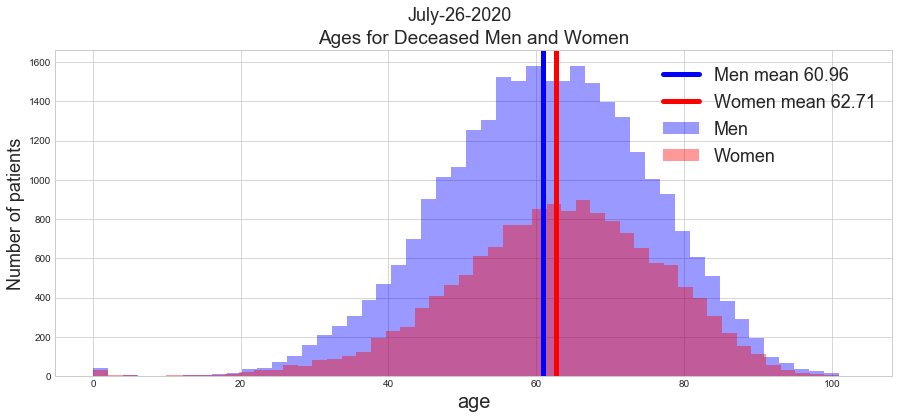

In [21]:
men_deceased_age = Covid('all').patients().men().deaths().infected().data.age.copy()
women_deceased_age = Covid('all').patients().women().deaths().infected().data.age.copy()

men_deceased_age.hist(bins = 51, alpha = 0.4, color = 'b', label='Men')
plt.axvline(np.mean(men_deceased_age), 0, label= f'Men mean {str(np.mean(men_deceased_age))[:5]}',color = 'b', linewidth = 5)

women_deceased_age.hist(bins = 51, alpha = 0.4, color = 'r', label='Women')
plt.axvline(np.mean(women_deceased_age), 0, label= f'Women mean {str(np.mean(women_deceased_age))[:5]}', color= 'r', linewidth = 5)

plt.ylabel('Number of patients',fontsize=18)
plt.xlabel('age',fontsize=20)
plt.title('Ages for Deceased Men and Women', fontsize= 19)
plt.suptitle(calendar.month_name[int(Covid.database['patients'][2:4])]+'-'+Covid.database['patients'][4:6]+'-20'+Covid.database['patients'][:2], fontsize=18)
plt.legend(fontsize=18)
plt.show()


## Probability density for age of death Men vs Women

Text(0.5, 0.98, 'July-26-2020')

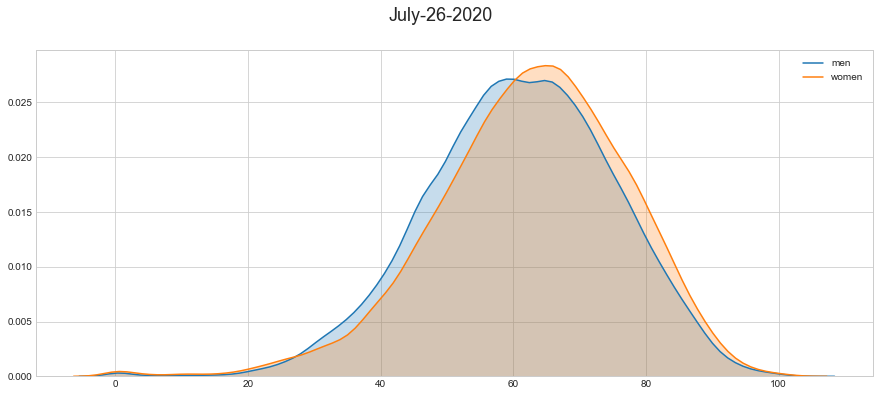

In [22]:
sns.kdeplot(men_deceased_age, shade=True, label = 'men')
sns.kdeplot(women_deceased_age, shade=True, label = 'women')
plt.suptitle(calendar.month_name[int(Covid.database['patients'][2:4])]+'-'+Covid.database['patients'][4:6]+'-20'+Covid.database['patients'][:2], fontsize=18)

## Is the age of death different for Women and Men?

In [23]:
# T test for independent samples, to see if the two distributions are the same
from scipy.stats import ttest_ind

_, pv = ttest_ind(men_deceased_age, women_deceased_age)

if pv < 0.01:
    print(f'The two samples are distinct, alpha = {pv}')
else:
    print('There is not difference between samples')

difference_between_samples = round(Covid.cohens_d(men_deceased_age, women_deceased_age),2)

print(f'Men are {difference_between_samples} stds away from Women')


The two samples are distinct, alpha = 9.199408294076268e-35
Men are -0.12 stds away from Women


## Men and Women active infections

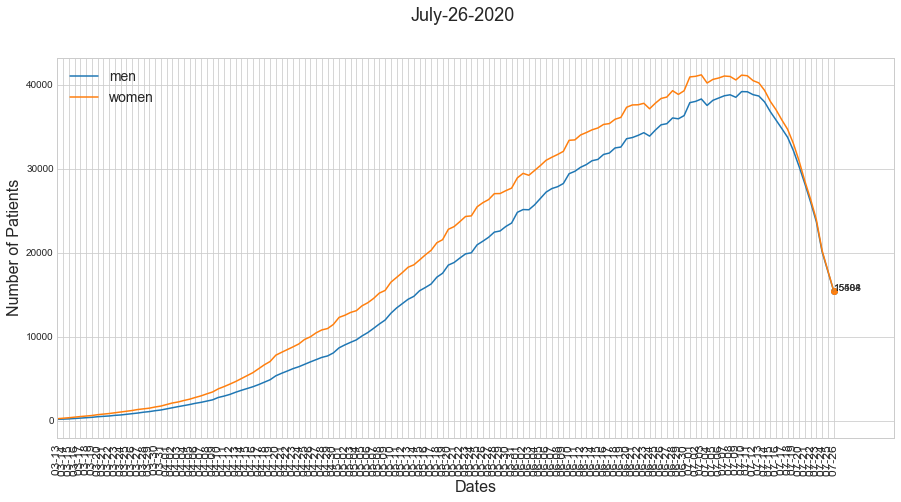

In [24]:
men_active   = Covid('all').patients().women().actives()
women_active = Covid('all').patients().men().actives()

Covid.plot_actives(data  = [men_active, women_active],
                   names = ['men','women'],
                   trim = 60)

## Different in illness for Infected Men and Women

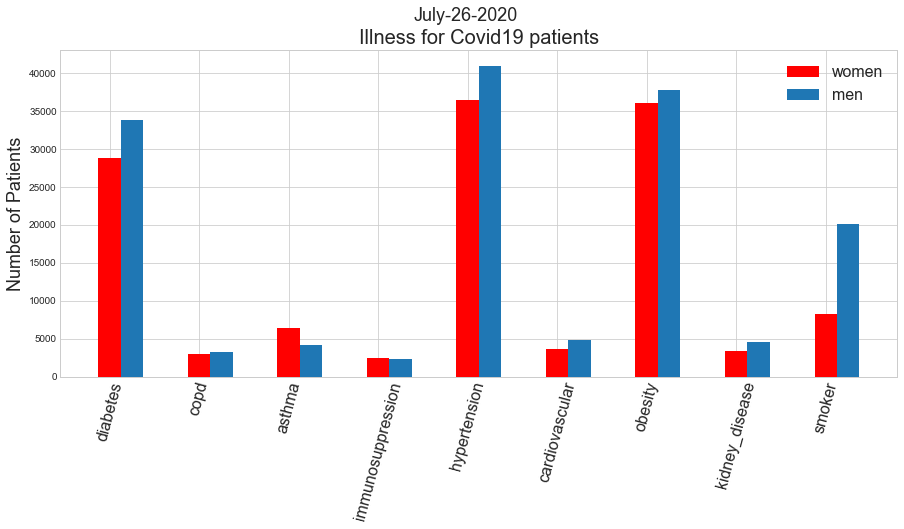

In [25]:
men_infected_illness = Covid('all').patients().men().infected().illness().drop(['sex','age'],axis=1)
women_infected_illness = Covid('all').patients().women().infected().illness().drop(['sex','age'],axis=1)

plt.close('all')
plt.rcParams["figure.figsize"] = (15,6)

plt.bar(list(women_infected_illness.keys()), [sum(women_infected_illness[x]) for x in women_infected_illness.keys()], color='r',width = 0.25, label='women')
plt.bar([x + 0.25 for x in range(9)], [sum(men_infected_illness[x]) for x in men_infected_illness.keys()],width = 0.25, label='men')

plt.xticks(fontsize = 16, rotation= 75)
plt.legend(fontsize=16)
plt.ylabel('Number of Patients', fontsize=18)
plt.suptitle(calendar.month_name[int(Covid.database['patients'][2:4])]+'-'+Covid.database['patients'][4:6]+'-20'+Covid.database['patients'][:2], fontsize=18)
plt.title('Illness for Covid19 patients', fontsize=20)
plt.show()

## Difference in illness between dead and alive Covid19 Patients

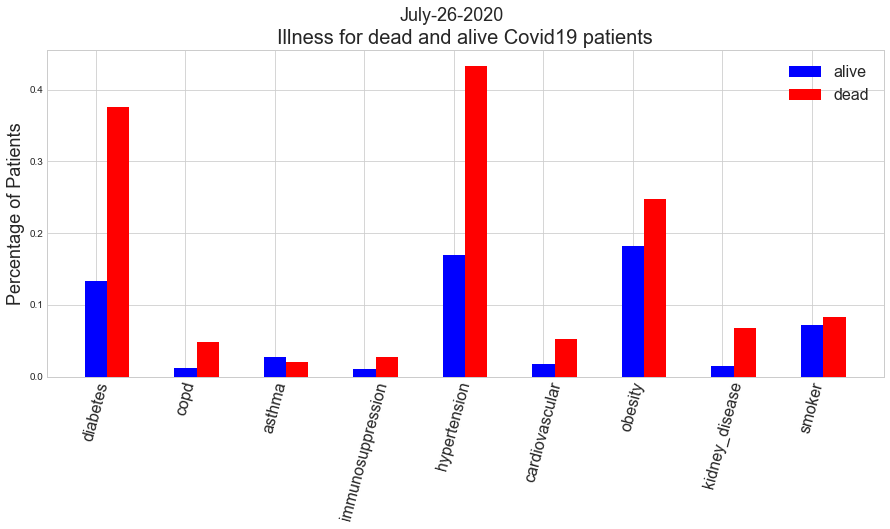

In [26]:
alive_illness = Covid('all').patients().infected().alive().illness().drop(['sex','age'],axis=1)
death_illness = Covid('all').patients().infected().deaths().illness().drop(['sex','age'],axis=1)
total_alive = len(alive_illness)
total_deaths = len(death_illness)

plt.close('all')
plt.rcParams["figure.figsize"] = (15,6)

plt.bar(list(alive_illness.keys()), [sum(alive_illness[x])/total_alive for x in alive_illness.keys()], color='b',width = 0.25, label='alive')
plt.bar([x + 0.25 for x in range(9)], [sum(death_illness[x])/total_deaths for x in death_illness.keys()], color = 'r',width = 0.25, label='dead')

plt.xticks(fontsize = 16, rotation= 75)
plt.legend(fontsize=16)
plt.ylabel('Percentage of Patients', fontsize=18)
plt.suptitle(calendar.month_name[int(Covid.database['patients'][2:4])]+'-'+Covid.database['patients'][4:6]+'-20'+Covid.database['patients'][:2], fontsize=18)
plt.title('Illness for dead and alive Covid19 patients', fontsize=20)
plt.show()

## Illness for Dead patients younger than 40

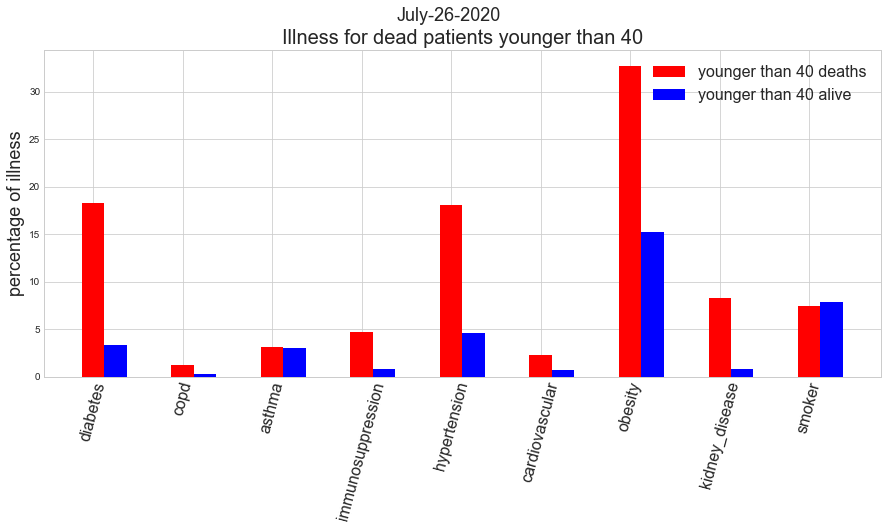

In [27]:
younger_than_40 = Covid('all').patients().deaths().infected().age(start = 0,end = 40).illness().drop(['sex','age'],axis=1)
alive_younger_than_40 = Covid('all').patients().alive().infected().age(start = 0,end = 40).illness().drop(['sex','age'],axis=1)

plt.close('all')
plt.rcParams["figure.figsize"] = (15,6)

plt.bar(list(younger_than_40.keys()), [sum(younger_than_40[x])/len(younger_than_40)*100 for x in younger_than_40.keys()],color = 'r', width = 0.25, label='younger than 40 deaths')
plt.bar([x + 0.25 for x in range(9)], [sum(alive_younger_than_40[x])/len(alive_younger_than_40)*100 for x in alive_younger_than_40.keys()], color = 'b',width = 0.25, label='younger than 40 alive')

plt.xticks(fontsize = 16, rotation= 75)
plt.legend(fontsize=16)
plt.ylabel('percentage of illness', fontsize=18)
plt.suptitle(calendar.month_name[int(Covid.database['patients'][2:4])]+'-'+Covid.database['patients'][4:6]+'-20'+Covid.database['patients'][:2], fontsize=18)
plt.title('Illness for dead patients younger than 40', fontsize=20)
plt.show()

## Men and Women actives for every state, max to min

In [28]:
Covid.get_max_to_min('actives')

OrderedDict([('DISTRITO FEDERAL', 4497),
             ('GUANAJUATO', 2651),
             ('MEXICO', 1865),
             ('NUEVO LEON', 1821),
             ('COAHUILA', 1564),
             ('TABASCO', 1517),
             ('JALISCO', 1498),
             ('VERACRUZ', 1433),
             ('YUCATAN', 1361),
             ('PUEBLA', 1286),
             ('SAN LUIS POTOSI', 1020),
             ('QUINTANA ROO', 960),
             ('HIDALGO', 747),
             ('GUERRERO', 739),
             ('TAMAULIPAS', 721),
             ('BAJA CALIFORNIA SUR', 708),
             ('MICHOACAN', 603),
             ('DURANGO', 591),
             ('OAXACA', 589),
             ('ZACATECAS', 579),
             ('BAJA CALIFORNIA', 511),
             ('SONORA', 493),
             ('SINALOA', 485),
             ('NAYARIT', 466),
             ('CAMPECHE', 402),
             ('COLIMA', 402),
             ('AGUASCALIENTES', 369),
             ('QUERETARO', 361),
             ('TLAXCALA', 276),
             ('MORELOS', 2

# State by State

# Mexico City:

### Confirmed, Suspicious and deaths

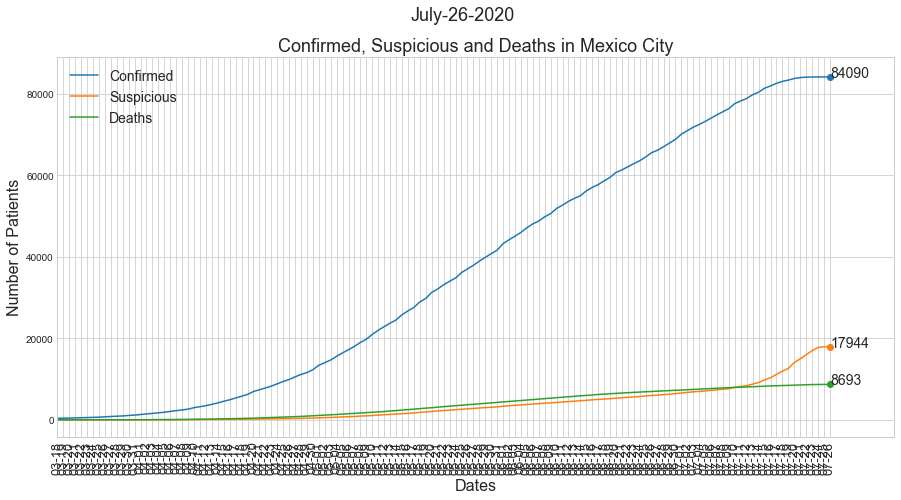

In [29]:
cdmx_confirmed = Covid('cdmx').cummulative('confirmed')
cdmx_suspicious= Covid('cdmx').cummulative('suspicious')
cdmx_deaths    = Covid('cdmx').cummulative('deaths')
Covid.plot_cummulative(data = [cdmx_confirmed,
                               cdmx_suspicious,
                               cdmx_deaths],
                    names = ['Confirmed','Suspicious','Deaths'],
                    trim = 70,
                    title = 'Confirmed, Suspicious and Deaths in Mexico City')

### Actives:

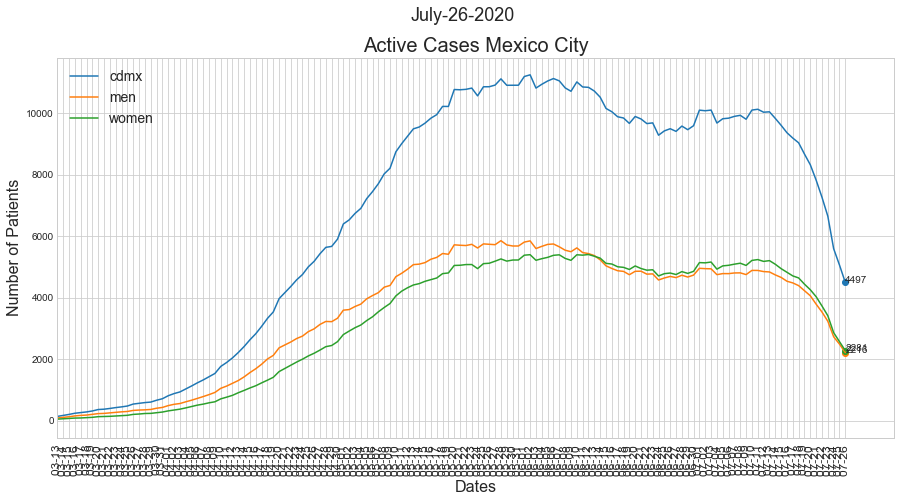

In [30]:
cdmx_actives = Covid('cdmx').patients().actives()
cdmx_men_active   = Covid('cdmx').patients().men().actives()
cdmx_women_active = Covid('cdmx').patients().women().actives()

Covid.plot_actives(data  = [cdmx_actives,
                            cdmx_men_active,
                            cdmx_women_active],
                   names = ['cdmx','men','women'],
                   trim = 20,
                   title= 'Active Cases Mexico City')

# Mexico State:

### Confirmed, Suspicious and deaths

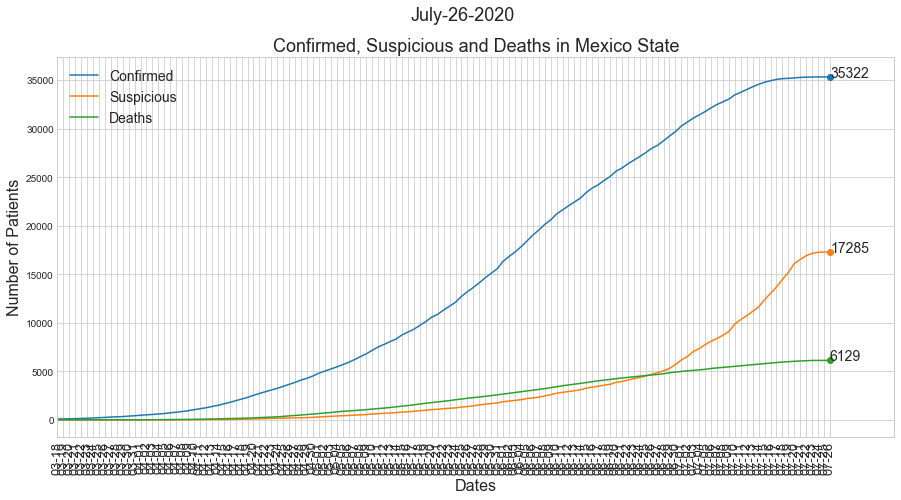

In [31]:
mexico_state_confirmed = Covid('MEXICO').cummulative('confirmed')
mexico_state_suspicious= Covid('MEXICO').cummulative('suspicious')
mexico_state_deaths    = Covid('MEXICO').cummulative('deaths')
Covid.plot_cummulative(data = [mexico_state_confirmed,
                               mexico_state_suspicious,
                               mexico_state_deaths],
                    names = ['Confirmed','Suspicious','Deaths'],
                    trim = 70,
                    title = 'Confirmed, Suspicious and Deaths in Mexico State')

### Actives:

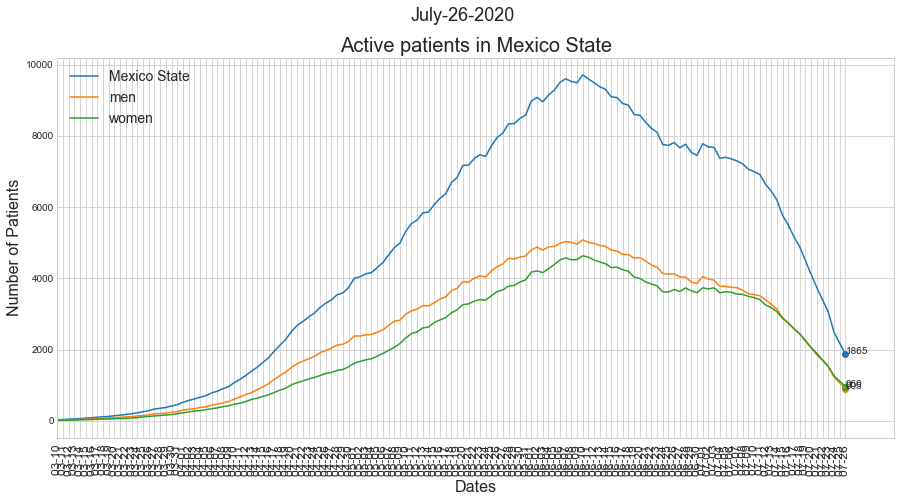

In [32]:
mexico_state_active       = Covid('MEXICO').patients().actives()
mexico_state_men_active   = Covid('MEXICO').patients().men().actives()
mexico_state_women_active = Covid('MEXICO').patients().women().actives()

Covid.plot_actives(data  = [mexico_state_active,
                            mexico_state_men_active,
                            mexico_state_women_active],
                   names = ['Mexico State','men','women'],
                   trim = 20,
                   title = 'Active patients in Mexico State')

# Tabasco

### Confirmed, Suspicious and deaths

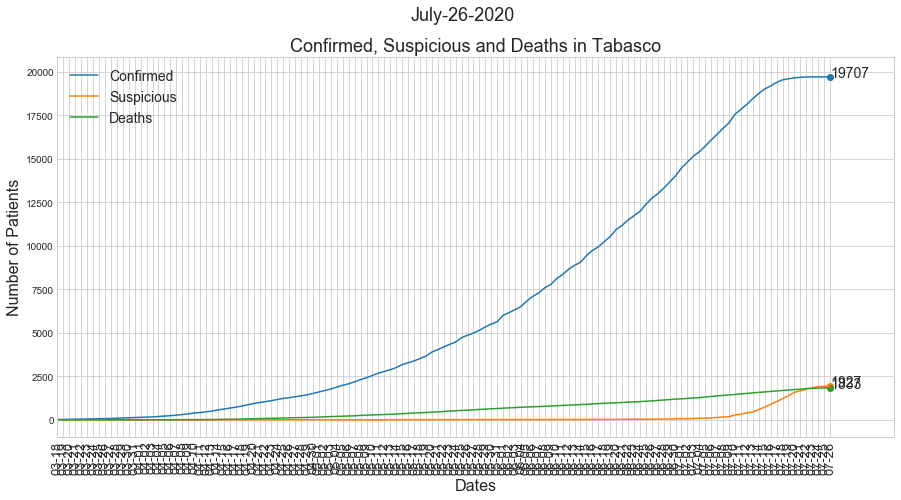

In [33]:
tabasco_confirmed = Covid('TABASCO').cummulative('confirmed')
tabasco_suspicious= Covid('TABASCO').cummulative('suspicious')
tabasco_deaths    = Covid('TABASCO').cummulative('deaths')
Covid.plot_cummulative(data = [tabasco_confirmed,
                               tabasco_suspicious,
                               tabasco_deaths],
                    names = ['Confirmed','Suspicious','Deaths'],
                    trim = 70,
                    title = 'Confirmed, Suspicious and Deaths in Tabasco')

### Actives

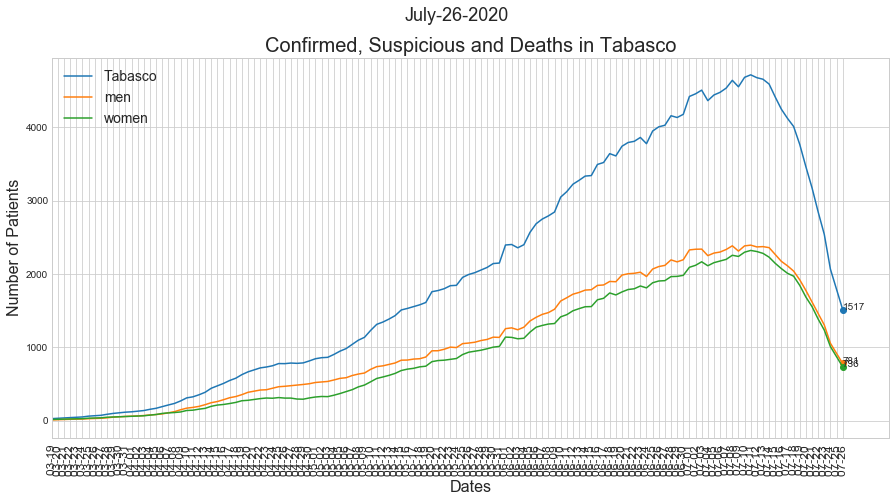

In [34]:
tabasco_active       = Covid('TABASCO').patients().actives()
tabasco_men_active   = Covid('TABASCO').patients().men().actives()
tabasco_women_active = Covid('TABASCO').patients().women().actives()

Covid.plot_actives(data  = [tabasco_active,
                            tabasco_men_active,
                            tabasco_women_active],
                   names = ['Tabasco','men','women'],
                   trim = 10,
                   title = 'Confirmed, Suspicious and Deaths in Tabasco')

# Guanajuato

### Confirmed, Suspicious and deaths

In [35]:
guanajuato_confirmed = Covid('GUANAJUATO').cummulative('confirmed')
guanajuato_suspicious= Covid('GUANAJUATO').cummulative('suspicious')
guanajuato_deaths    = Covid('GUANAJUATO').cummulative('deaths')
Covid.plot_cummulative(data = [guanajuato_confirmed,
                               guanajuato_suspicious,
                               guanajuato_deaths],
                    names = ['Confirmed','Suspicious','Deaths'],
                    trim = 70,
                    title = 'Confirmed, Suspicious and Deaths in Guanajuato')

### Actives

In [36]:
guanajuato_active       = Covid('GUANAJUATO').patients().actives()
guanajuato_men_active   = Covid('GUANAJUATO').patients().men().actives()
guanajuato_women_active = Covid('GUANAJUATO').patients().women().actives()

Covid.plot_actives(data  = [guanajuato_active,
                            guanajuato_men_active,
                            guanajuato_women_active],
                   names = ['Guanajuato','men','women'],
                   trim = 5,
                   title = 'Active patients in Guanajuato')

# Jalisco

### Confirmed, Suspicious and deaths

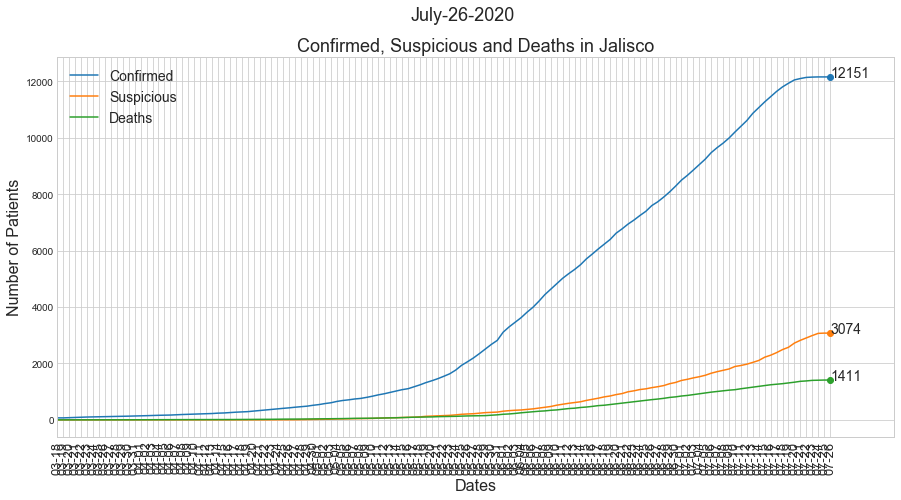

In [37]:
jalisco_confirmed = Covid('JALISCO').cummulative('confirmed')
jalisco_suspicious= Covid('JALISCO').cummulative('suspicious')
jalisco_deaths    = Covid('JALISCO').cummulative('deaths')
Covid.plot_cummulative(data = [jalisco_confirmed,
                               jalisco_suspicious,
                               jalisco_deaths],
                    names = ['Confirmed','Suspicious','Deaths'],
                    trim = 70,
                    title = 'Confirmed, Suspicious and Deaths in Jalisco')

### Actives

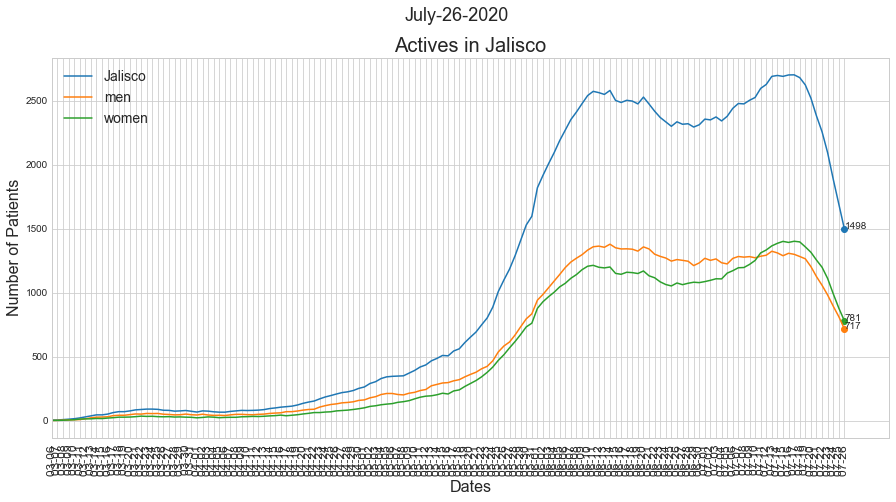

In [38]:
jalisco_active       = Covid('JALISCO').patients().actives()
jalisco_men_active   = Covid('JALISCO').patients().men().actives()
jalisco_women_active = Covid('JALISCO').patients().women().actives()

Covid.plot_actives(data  = [jalisco_active,
                            jalisco_men_active,
                            jalisco_women_active],
                   names = ['Jalisco','men','women'],
                   trim = 5,
                   title = 'Actives in Jalisco')

# Puebla

### Confirmed, Suspicious and deaths

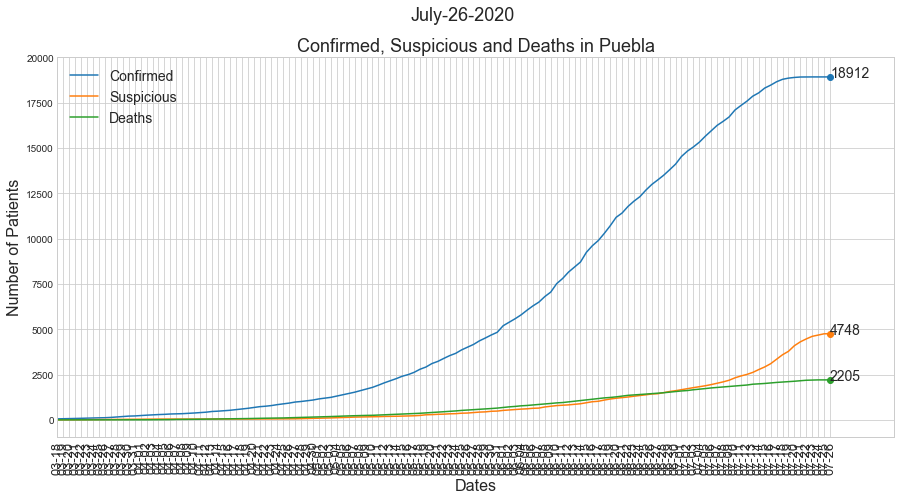

In [39]:
puebla_confirmed = Covid('PUEBLA').cummulative('confirmed')
puebla_suspicious= Covid('PUEBLA').cummulative('suspicious')
puebla_deaths    = Covid('PUEBLA').cummulative('deaths')
Covid.plot_cummulative(data = [puebla_confirmed,
                               puebla_suspicious,
                               puebla_deaths],
                    names = ['Confirmed','Suspicious','Deaths'],
                    trim = 70,
                    title = 'Confirmed, Suspicious and Deaths in Puebla')

### Actives

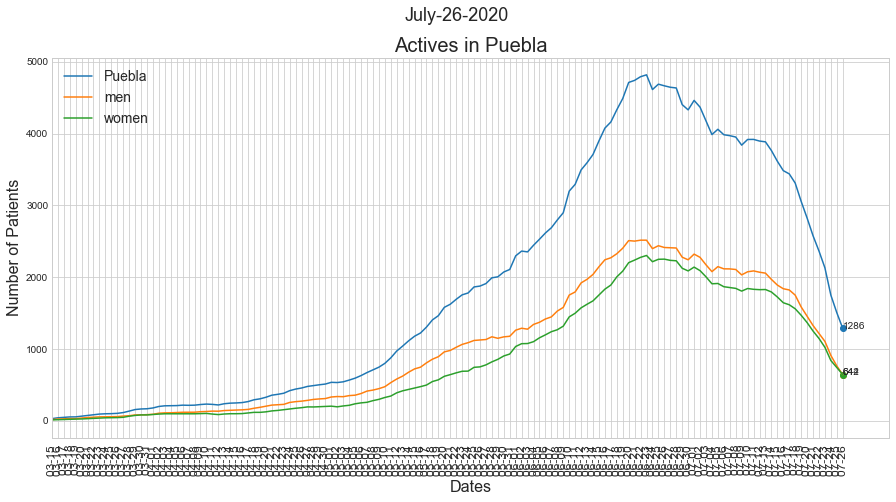

In [40]:
puebla_active   = Covid('PUEBLA').patients().actives()
puebla_men_active   = Covid('PUEBLA').patients().men().actives()
puebla_women_active = Covid('PUEBLA').patients().women().actives()

Covid.plot_actives(data  = [puebla_active,
                            puebla_men_active,
                            puebla_women_active],
                   names = ['Puebla','men','women'],
                   trim = 10,
                   title = 'Actives in Puebla')

# Veracruz

### Confirmed, Suspicious and deaths

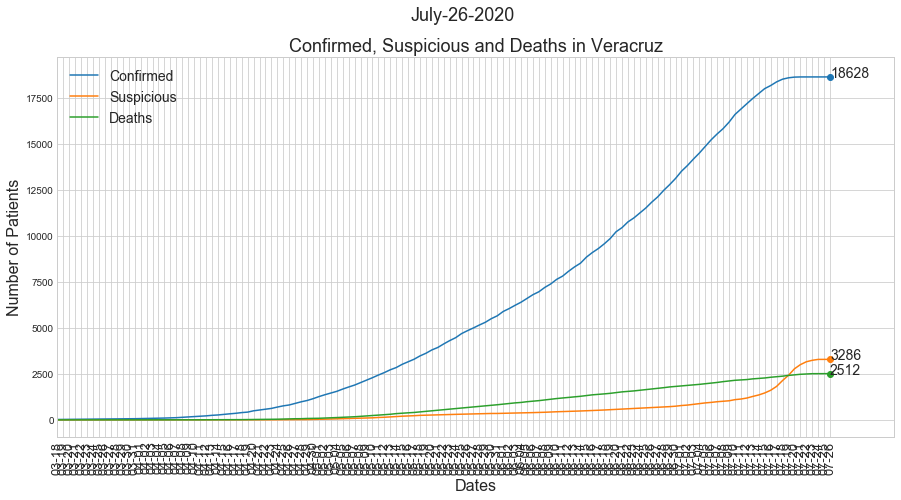

In [41]:
veracruz_confirmed = Covid('VERACRUZ').cummulative('confirmed')
veracruz_suspicious= Covid('VERACRUZ').cummulative('suspicious')
veracruz_deaths    = Covid('VERACRUZ').cummulative('deaths')
Covid.plot_cummulative(data = [veracruz_confirmed,
                               veracruz_suspicious,
                               veracruz_deaths],
                    names = ['Confirmed','Suspicious','Deaths'],
                    trim = 70,
                    title = 'Confirmed, Suspicious and Deaths in Veracruz')

### Actives

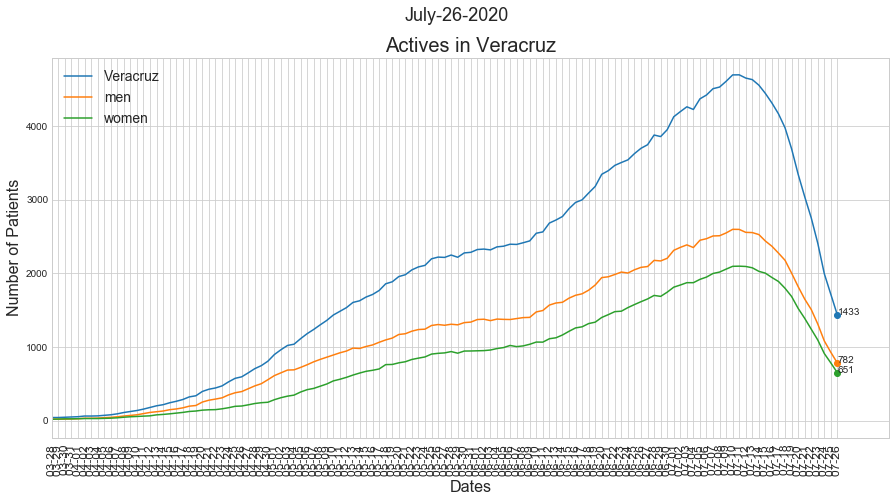

In [42]:
veracruz_active       = Covid('VERACRUZ').patients().actives()
veracruz_men_active   = Covid('VERACRUZ').patients().men().actives()
veracruz_women_active = Covid('VERACRUZ').patients().women().actives()

Covid.plot_actives(data  = [veracruz_active,
                            veracruz_men_active,
                            veracruz_women_active],
                   names = ['Veracruz','men','women'],
                   trim = 25,
                   title = 'Actives in Veracruz')

# Chiapas

### Confirmed, Suspicious and deaths

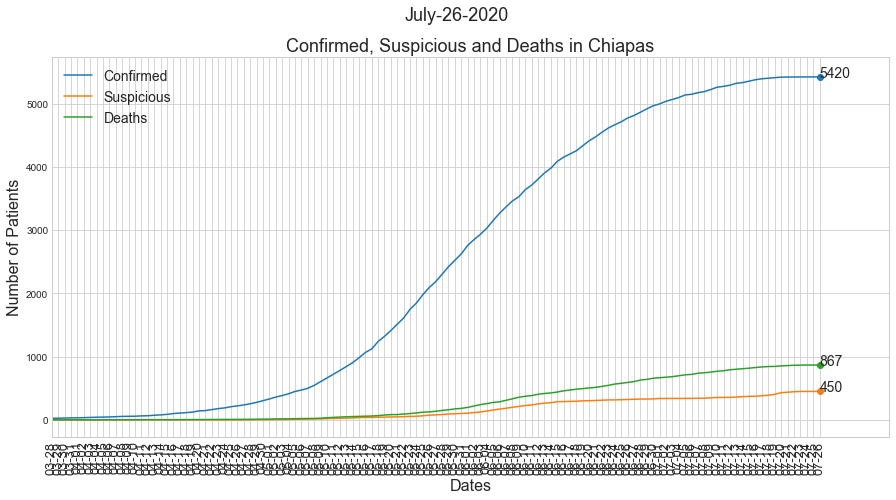

In [43]:
chiapas_confirmed = Covid('CHIAPAS').cummulative('confirmed')
chiapas_suspicious= Covid('CHIAPAS').cummulative('suspicious')
chiapas_deaths    = Covid('CHIAPAS').cummulative('deaths')
Covid.plot_cummulative(data = [chiapas_confirmed,
                               chiapas_suspicious,
                               chiapas_deaths],
                    names = ['Confirmed','Suspicious','Deaths'],
                    trim = 80,
                    title = 'Confirmed, Suspicious and Deaths in Chiapas')

### Actives

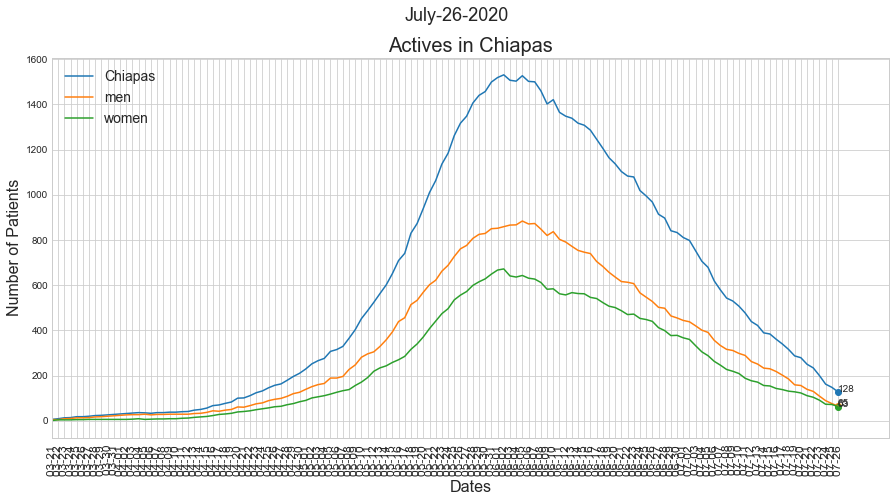

In [44]:
chiapas_active       = Covid('CHIAPAS').patients().actives()
chiapas_men_active   = Covid('CHIAPAS').patients().men().actives()
chiapas_women_active = Covid('CHIAPAS').patients().women().actives()

Covid.plot_actives(data  = [chiapas_active,
                            chiapas_men_active,
                            chiapas_women_active],
                   names = ['Chiapas','men','women'],
                   trim = 25,
                   title = 'Actives in Chiapas')

# Sinaloa

### Confirmed, Suspicious and deaths

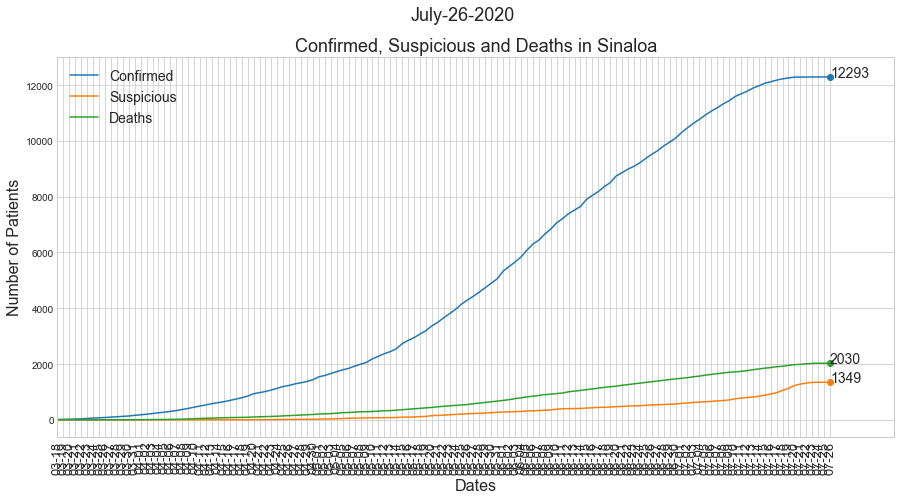

In [45]:
sinaloa_confirmed = Covid('SINALOA').cummulative('confirmed')
sinaloa_suspicious= Covid('SINALOA').cummulative('suspicious')
sinaloa_deaths    = Covid('SINALOA').cummulative('deaths')
Covid.plot_cummulative(data = [sinaloa_confirmed,
                               sinaloa_suspicious,
                               sinaloa_deaths],
                    names = ['Confirmed','Suspicious','Deaths'],
                    trim = 70,
                    title = 'Confirmed, Suspicious and Deaths in Sinaloa')

### Actives

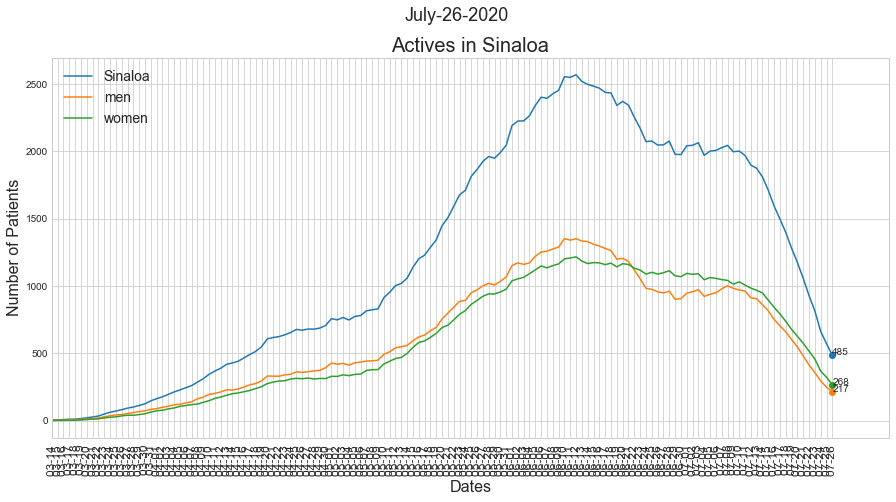

In [46]:
sinaloa_active       = Covid('SINALOA').patients().actives()
sinaloa_men_active   = Covid('SINALOA').patients().men().actives()
sinaloa_women_active = Covid('SINALOA').patients().women().actives()

Covid.plot_actives(data  = [sinaloa_active,
                            sinaloa_men_active,
                            sinaloa_women_active],
                   names = ['Sinaloa','men','women'],
                   trim = 45,
                   title = 'Actives in Sinaloa')

# Baja California

### Confirmed, Suspicious and deaths

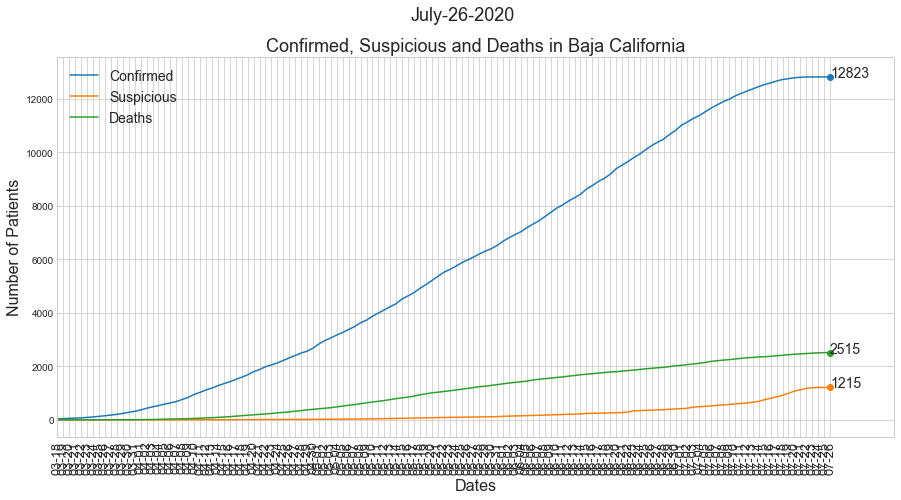

In [47]:
bcalifornia_confirmed = Covid('BAJA CALIFORNIA').cummulative('confirmed')
bcalifornia_suspicious= Covid('BAJA CALIFORNIA').cummulative('suspicious')
bcalifornia_deaths    = Covid('BAJA CALIFORNIA').cummulative('deaths')
Covid.plot_cummulative(data = [bcalifornia_confirmed,
                               bcalifornia_suspicious,
                               bcalifornia_deaths],
                    names = ['Confirmed','Suspicious','Deaths'],
                    trim = 70,
                    title = 'Confirmed, Suspicious and Deaths in Baja California')

### Actives

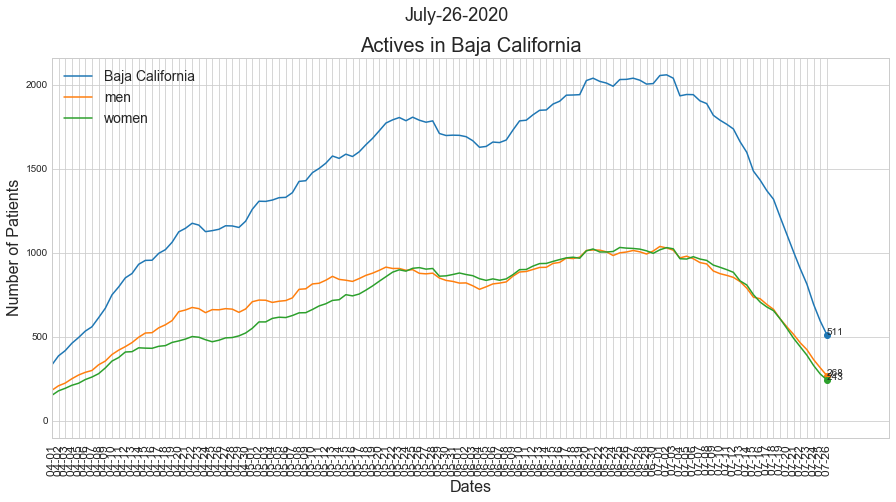

In [48]:
bcalifornia_active       = Covid('BAJA CALIFORNIA').patients().actives()
bcalifornia_men_active   = Covid('BAJA CALIFORNIA').patients().men().actives()
bcalifornia_women_active = Covid('BAJA CALIFORNIA').patients().women().actives()

Covid.plot_actives(data  = [bcalifornia_active,
                            bcalifornia_men_active,
                            bcalifornia_women_active],
                   names = ['Baja California','men','women'],
                   trim = 55,
                   title = 'Actives in Baja California')

# Sonora

### Confirmed, Suspicious and deaths

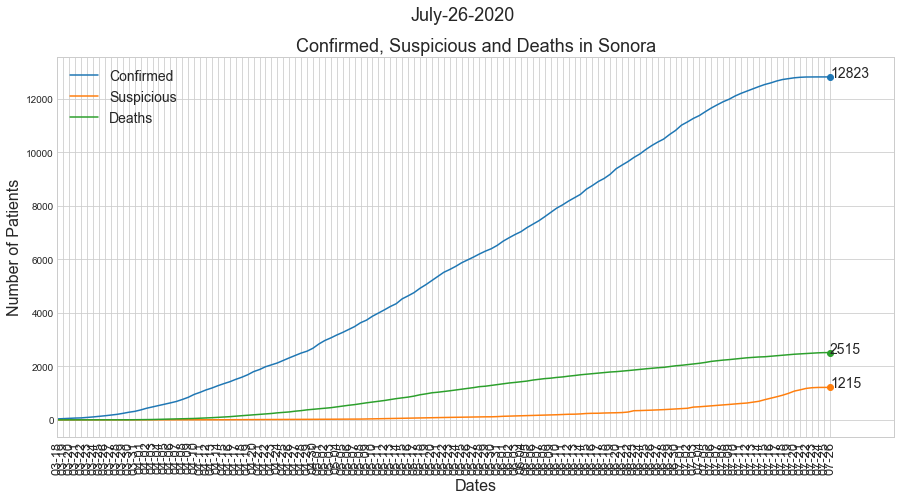

In [49]:
sonora_confirmed = Covid('SONORA').cummulative('confirmed')
sonora_suspicious= Covid('SONORA').cummulative('suspicious')
sonora_deaths    = Covid('SONORA').cummulative('deaths')
Covid.plot_cummulative(data = [bcalifornia_confirmed,
                               bcalifornia_suspicious,
                               bcalifornia_deaths],
                    names = ['Confirmed','Suspicious','Deaths'],
                    trim = 70,
                    title = 'Confirmed, Suspicious and Deaths in Sonora')

### Actives

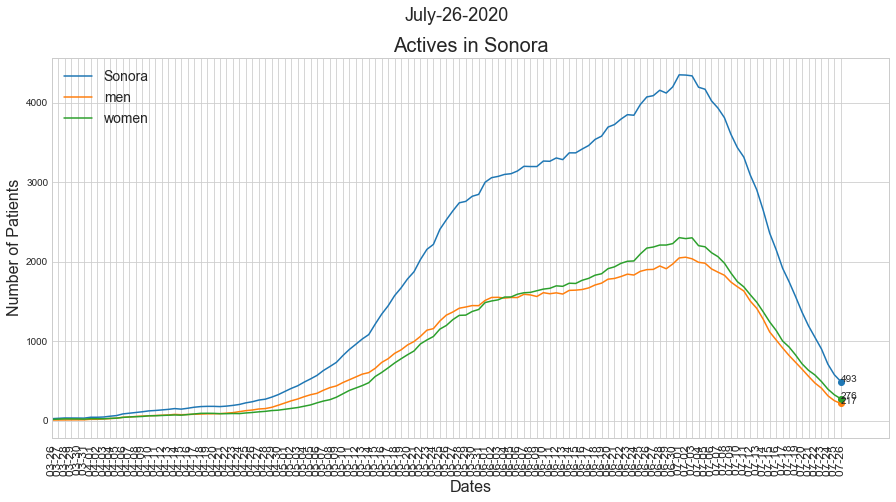

In [50]:
sonora_active       = Covid('SONORA').patients().actives()
sonora_men_active   = Covid('SONORA').patients().men().actives()
sonora_women_active = Covid('SONORA').patients().women().actives()

Covid.plot_actives(data  = [sonora_active,
                            sonora_men_active,
                            sonora_women_active],
                   names = ['Sonora','men','women'],
                   trim = 15,
                   title = 'Actives in Sonora')

# Hidalgo

### Confirmed, Suspicious and deaths

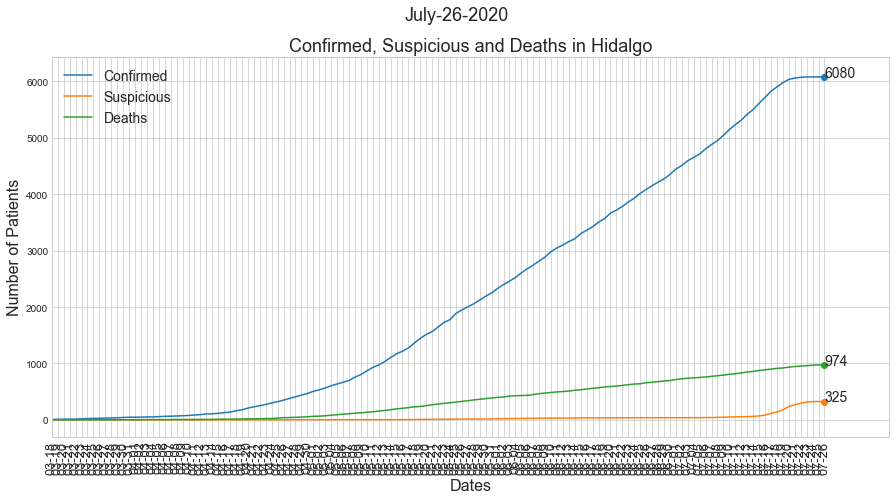

In [51]:
hidalgo_confirmed = Covid('HIDALGO').cummulative('confirmed')
hidalgo_suspicious= Covid('HIDALGO').cummulative('suspicious')
hidalgo_deaths    = Covid('HIDALGO').cummulative('deaths')
Covid.plot_cummulative(data = [hidalgo_confirmed,
                               hidalgo_suspicious,
                               hidalgo_deaths],
                    names = ['Confirmed','Suspicious','Deaths'],
                    trim = 70,
                    title = 'Confirmed, Suspicious and Deaths in Hidalgo')

### Actives

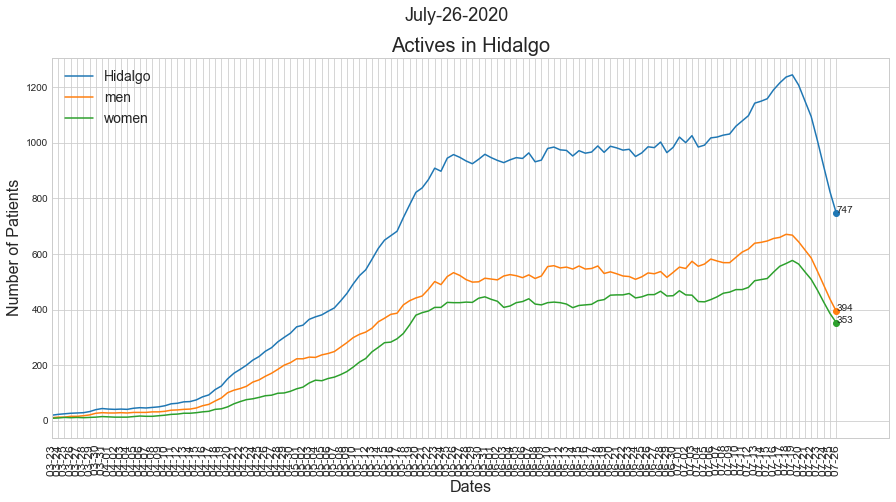

In [52]:
hidalgo_active       = Covid('HIDALGO').patients().actives()
hidalgo_men_active   = Covid('HIDALGO').patients().men().actives()
hidalgo_women_active = Covid('HIDALGO').patients().women().actives()

Covid.plot_actives(data  = [hidalgo_active,
                            hidalgo_men_active,
                            hidalgo_women_active],
                   names = ['Hidalgo','men','women'],
                   trim = 30,
                  title = 'Actives in Hidalgo')

# Nuevo León

### Confirmed, Suspicious and Deaths

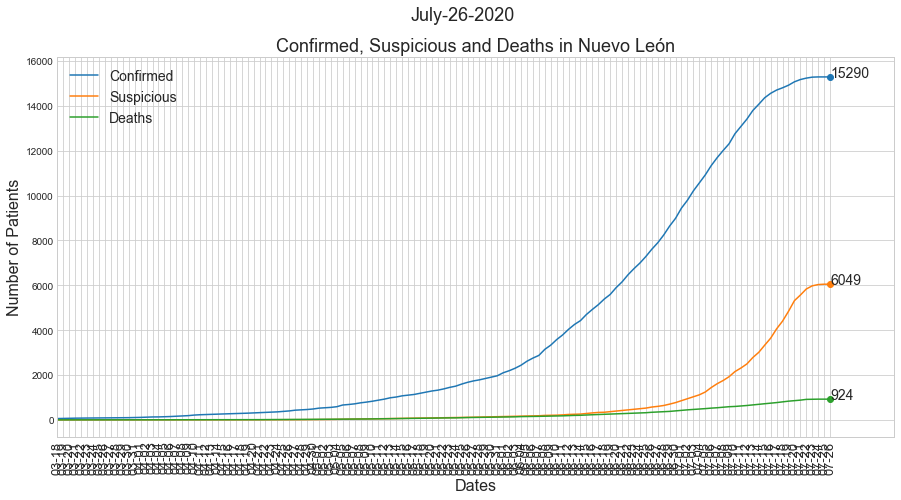

In [53]:
nleon_confirmed = Covid('NUEVO LEON').cummulative('confirmed')
nleon_suspicious= Covid('NUEVO LEON').cummulative('suspicious')
nleon_deaths    = Covid('NUEVO LEON').cummulative('deaths')
Covid.plot_cummulative(data = [nleon_confirmed,
                               nleon_suspicious,
                               nleon_deaths],
                    names = ['Confirmed','Suspicious','Deaths'],
                    trim = 70,
                    title = 'Confirmed, Suspicious and Deaths in Nuevo León')

### Actives

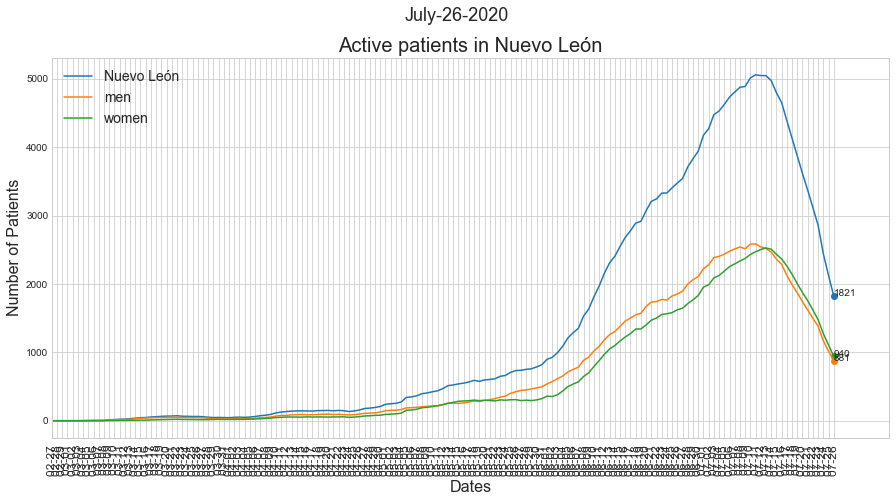

In [54]:
nleon_active   = Covid('NUEVO LEON').patients().actives()

nleon_men_active   = Covid('NUEVO LEON').patients().men().actives()
nleon_women_active = Covid('NUEVO LEON').patients().women().actives()

Covid.plot_actives(data  = [nleon_active,
                            nleon_men_active,
                            nleon_women_active],
                   names = ['Nuevo León','men','women'],
                   trim = 45,
                   title = 'Active patients in Nuevo León')

# Oaxaca

### Confirmed, Suspicious and Deaths

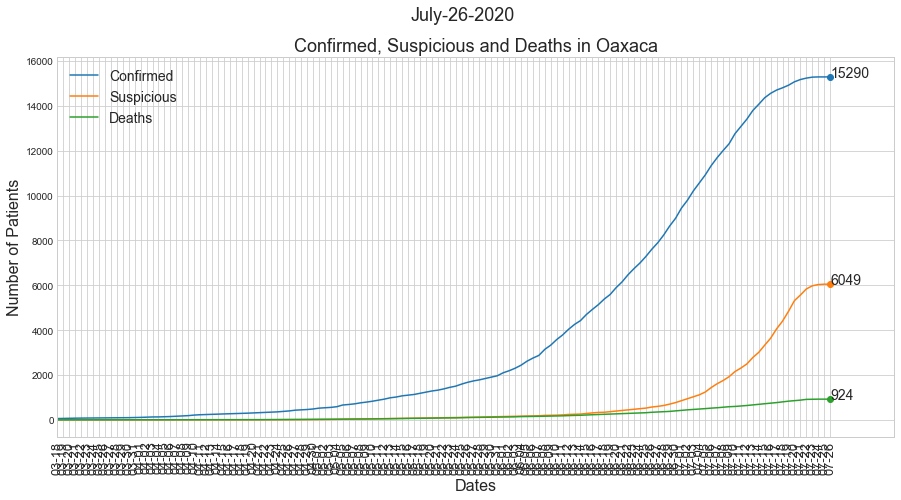

In [55]:
oaxaca_confirmed = Covid('NUEVO LEON').cummulative('confirmed')
oaxaca_suspicious= Covid('NUEVO LEON').cummulative('suspicious')
oaxaca_deaths    = Covid('NUEVO LEON').cummulative('deaths')
Covid.plot_cummulative(data = [oaxaca_confirmed,
                               oaxaca_suspicious,
                               oaxaca_deaths],
                    names = ['Confirmed','Suspicious','Deaths'],
                    trim = 70,
                    title = 'Confirmed, Suspicious and Deaths in Oaxaca')

### Actives

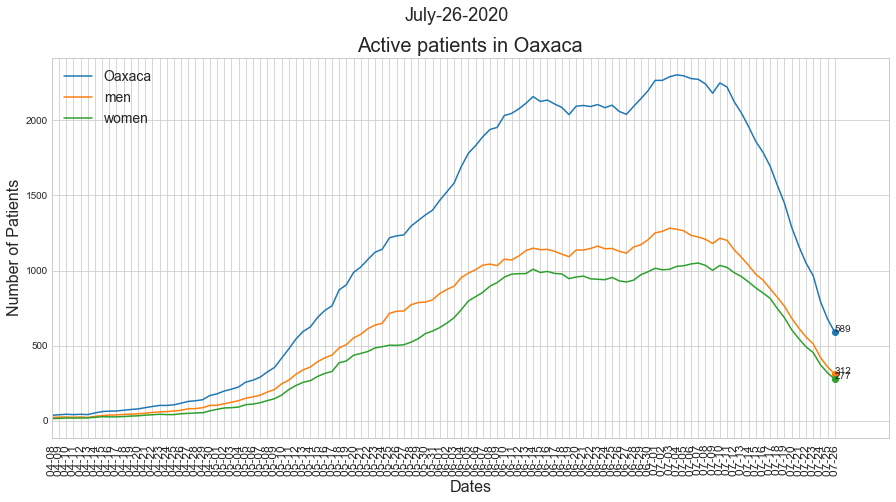

In [56]:
oaxaca_active   = Covid('OAXACA').patients().actives()

oaxaca_men_active   = Covid('OAXACA').patients().men().actives()
oaxaca_women_active = Covid('OAXACA').patients().women().actives()

Covid.plot_actives(data  = [oaxaca_active,
                            oaxaca_men_active,
                            oaxaca_women_active],
                   names = ['Oaxaca','men','women'],
                   trim = 30,
                   title = 'Active patients in Oaxaca')

# Michoacan

### Confirmed, Suspicious and Deaths

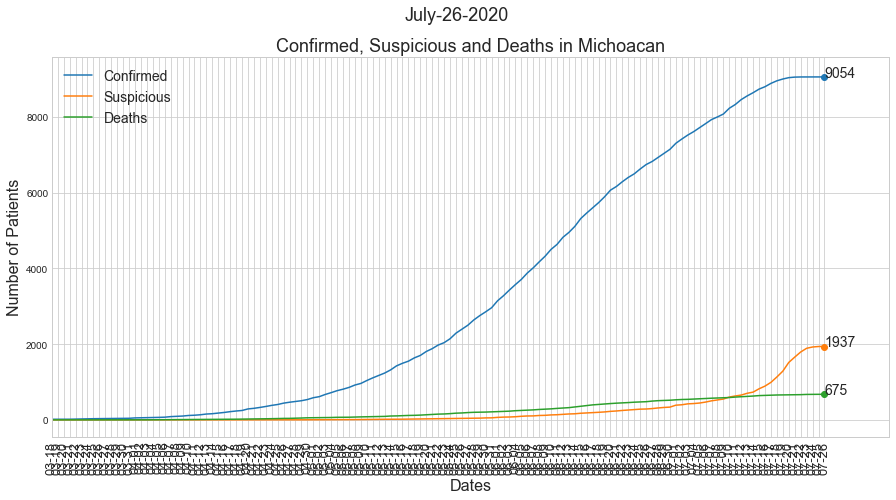

In [57]:
michoacan_confirmed = Covid('MICHOACAN').cummulative('confirmed')
michoacan_suspicious= Covid('MICHOACAN').cummulative('suspicious')
michoacan_deaths    = Covid('MICHOACAN').cummulative('deaths')
Covid.plot_cummulative(data = [michoacan_confirmed,
                               michoacan_suspicious,
                               michoacan_deaths],
                    names = ['Confirmed','Suspicious','Deaths'],
                    trim = 70,
                    title = 'Confirmed, Suspicious and Deaths in Michoacan')

### Actives

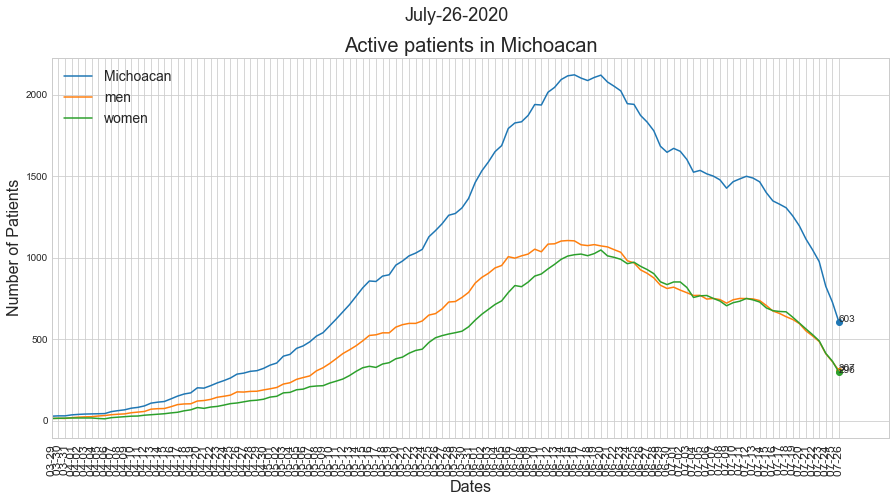

In [58]:
michoacan_active   = Covid('MICHOACAN').patients().actives()

michoacan_men_active   = Covid('MICHOACAN').patients().men().actives()
michoacan_women_active = Covid('MICHOACAN').patients().women().actives()

Covid.plot_actives(data  = [michoacan_active,
                            michoacan_men_active,
                            michoacan_women_active],
                   names = ['Michoacan','men','women'],
                   trim = 20,
                   title = 'Active patients in Michoacan')

# Yucatan

### Confirmed, Suspicious and Deaths

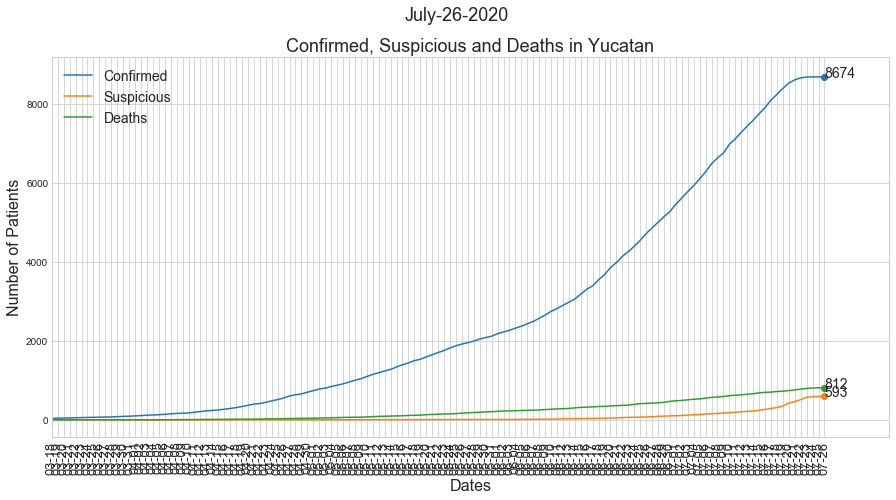

In [59]:
yucatan_confirmed = Covid('YUCATAN').cummulative('confirmed')
yucatan_suspicious= Covid('YUCATAN').cummulative('suspicious')
yucatan_deaths    = Covid('YUCATAN').cummulative('deaths')
Covid.plot_cummulative(data = [yucatan_confirmed,
                               yucatan_suspicious,
                               yucatan_deaths],
                    names = ['Confirmed','Suspicious','Deaths'],
                    trim = 70,
                    title = 'Confirmed, Suspicious and Deaths in Yucatan')

### Active

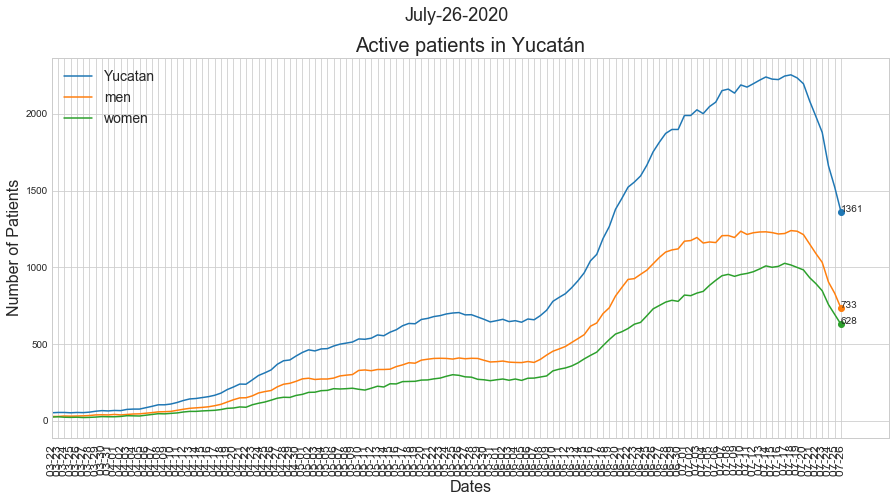

In [60]:
yucatan_active   = Covid('YUCATAN').patients().actives()

yucatan_men_active   = Covid('YUCATAN').patients().men().actives()
yucatan_women_active = Covid('YUCATAN').patients().women().actives()

Covid.plot_actives(data  = [yucatan_active,
                            yucatan_men_active,
                            yucatan_women_active],
                   names = ['Yucatan','men','women'],
                   trim = 15,
                   title = 'Active patients in Yucatán')

# Tamaulipas

### Confirmed, Suspicious and Deaths

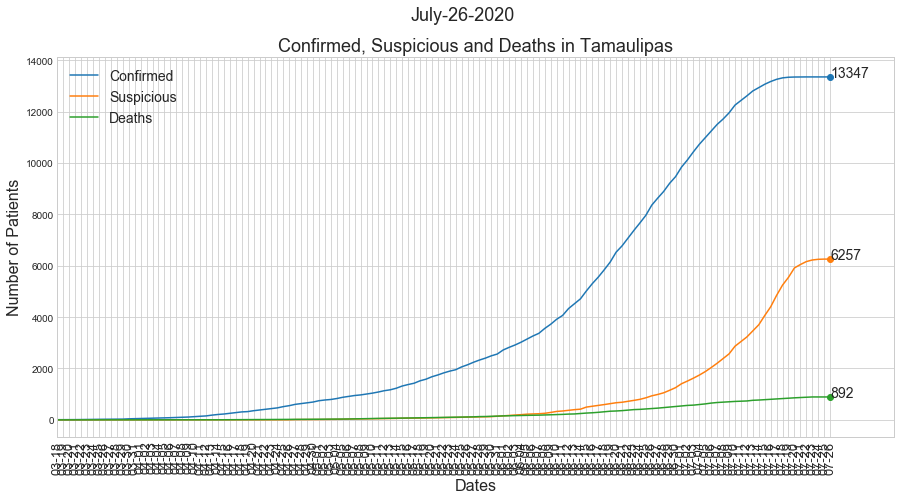

In [61]:
tamaulipas_confirmed = Covid('TAMAULIPAS').cummulative('confirmed')
tamaulipas_suspicious= Covid('TAMAULIPAS').cummulative('suspicious')
tamaulipas_deaths    = Covid('TAMAULIPAS').cummulative('deaths')
Covid.plot_cummulative(data = [tamaulipas_confirmed,
                               tamaulipas_suspicious,
                               tamaulipas_deaths],
                    names = ['Confirmed','Suspicious','Deaths'],
                    trim = 70,
                    title = 'Confirmed, Suspicious and Deaths in Tamaulipas')

### Actives

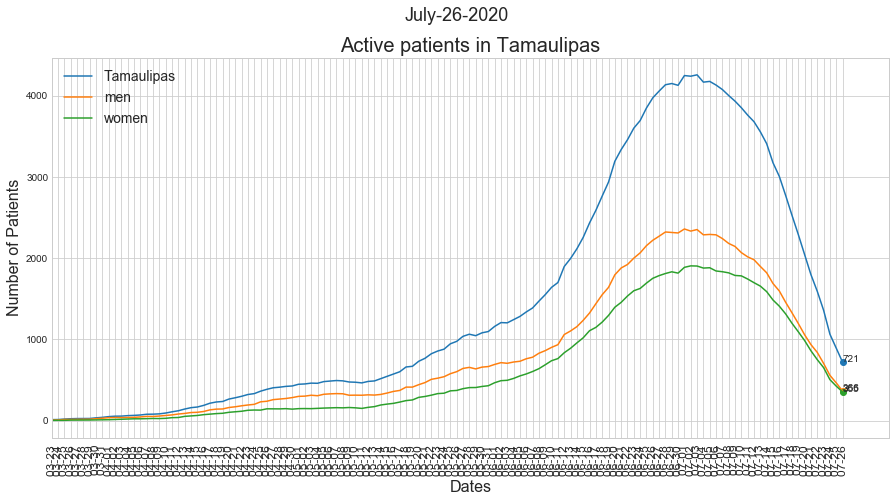

In [62]:
tamaulipas_active   = Covid('TAMAULIPAS').patients().actives()

tamaulipas_men_active   = Covid('TAMAULIPAS').patients().men().actives()
tamaulipas_women_active = Covid('TAMAULIPAS').patients().women().actives()

Covid.plot_actives(data  = [tamaulipas_active,
                            tamaulipas_men_active,
                            tamaulipas_women_active],
                   names = ['Tamaulipas','men','women'],
                   trim = 10,
                   title = 'Active patients in Tamaulipas')

# Aguascalientes

### Confirmed, Suspicious and Deaths

In [63]:
aguascalientes_confirmed = Covid('AGUASCALIENTES').cummulative('confirmed')
aguascalientes_suspicious= Covid('AGUASCALIENTES').cummulative('suspicious')
aguascalientes_deaths    = Covid('AGUASCALIENTES').cummulative('deaths')
Covid.plot_cummulative(data = [aguascalientes_confirmed,
                               aguascalientes_suspicious,
                               aguascalientes_deaths],
                    names = ['Confirmed','Suspicious','Deaths'],
                    trim = 70,
                    title = 'Confirmed, Suspicious and Deaths in Aguascalientes')

### Actives

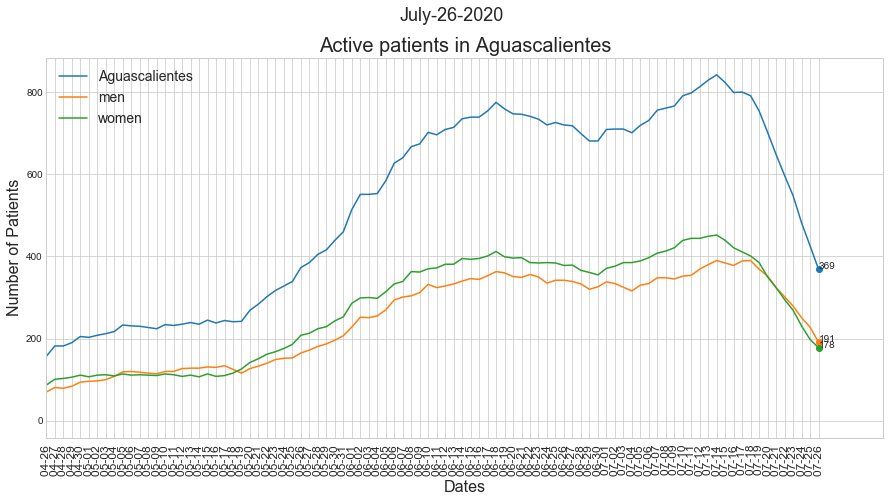

In [64]:
aguascalientes_active   = Covid('AGUASCALIENTES').patients().actives()

aguascalientes_men_active   = Covid('AGUASCALIENTES').patients().men().actives()
aguascalientes_women_active = Covid('AGUASCALIENTES').patients().women().actives()

Covid.plot_actives(data  = [aguascalientes_active,
                            aguascalientes_men_active,
                            aguascalientes_women_active],
                   names = ['Aguascalientes','men','women'],
                   trim = 50,
                   title = 'Active patients in Aguascalientes')

# San Luis Potosí

### Confirmed, Suspicious and Deaths

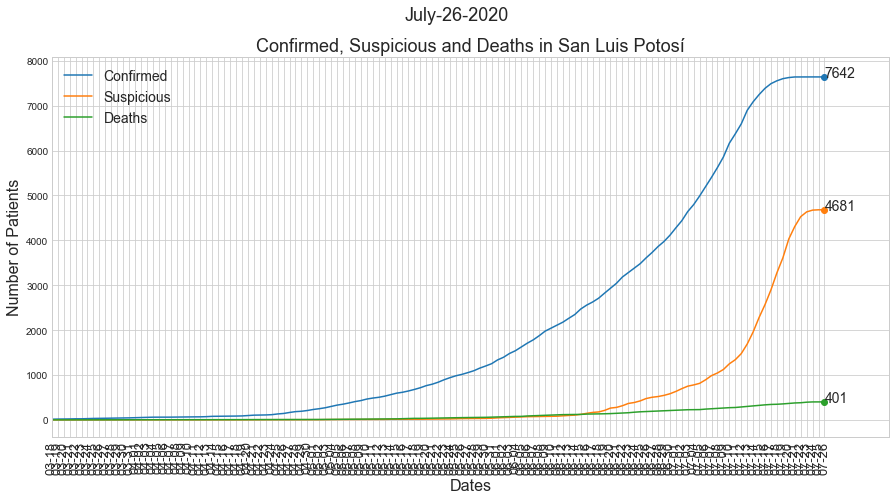

In [65]:
sanluis_confirmed = Covid('SAN LUIS POTOSI').cummulative('confirmed')
sanluis_suspicious= Covid('SAN LUIS POTOSI').cummulative('suspicious')
sanluis_deaths    = Covid('SAN LUIS POTOSI').cummulative('deaths')
Covid.plot_cummulative(data = [sanluis_confirmed,
                               sanluis_suspicious,
                               sanluis_deaths],
                    names = ['Confirmed','Suspicious','Deaths'],
                    trim = 70,
                    title = 'Confirmed, Suspicious and Deaths in San Luis Potosí')

### Actives

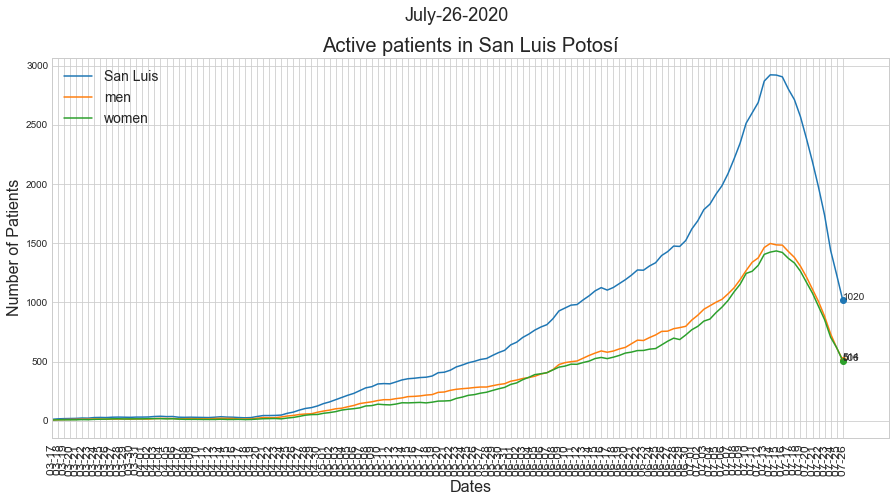

In [66]:
sanluis_active   = Covid('SAN LUIS POTOSI').patients().actives()

sanluis_men_active   = Covid('SAN LUIS POTOSI').patients().men().actives()
sanluis_women_active = Covid('SAN LUIS POTOSI').patients().women().actives()

Covid.plot_actives(data  = [sanluis_active,
                            sanluis_men_active,
                            sanluis_women_active],
                   names = ['San Luis','men','women'],
                   trim = 10,
                   title = 'Active patients in San Luis Potosí')

# Quintana Roo

### Confirmed, Suspicious and Deaths

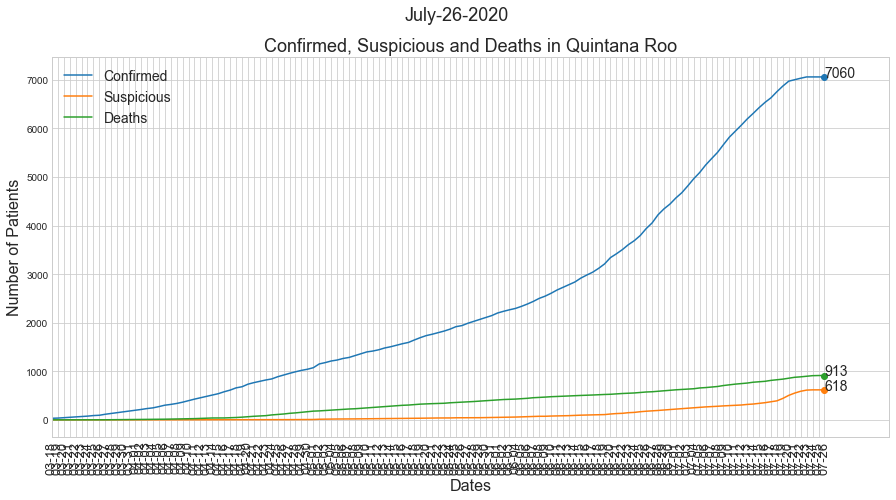

In [67]:
quintana_confirmed = Covid('QUINTANA ROO').cummulative('confirmed')
quintana_suspicious= Covid('QUINTANA ROO').cummulative('suspicious')
quintana_deaths    = Covid('QUINTANA ROO').cummulative('deaths')
Covid.plot_cummulative(data = [quintana_confirmed,
                               quintana_suspicious,
                               quintana_deaths],
                    names = ['Confirmed','Suspicious','Deaths'],
                    trim = 70,
                    title = 'Confirmed, Suspicious and Deaths in Quintana Roo')

### Actives

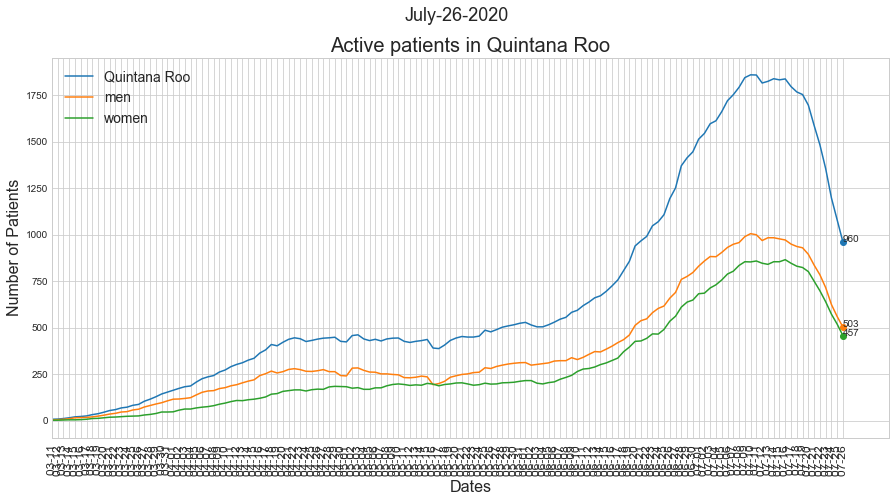

In [68]:
quintana_active   = Covid('QUINTANA ROO').patients().actives()

quintana_men_active   = Covid('QUINTANA ROO').patients().men().actives()
quintana_women_active = Covid('QUINTANA ROO').patients().women().actives()

Covid.plot_actives(data  = [quintana_active,
                            quintana_men_active,
                            quintana_women_active],
                   names = ['Quintana Roo','men','women'],
                   trim = 10,
                   title = 'Active patients in Quintana Roo')

# Coahuila

### Confirmed, Suspicious and Deaths

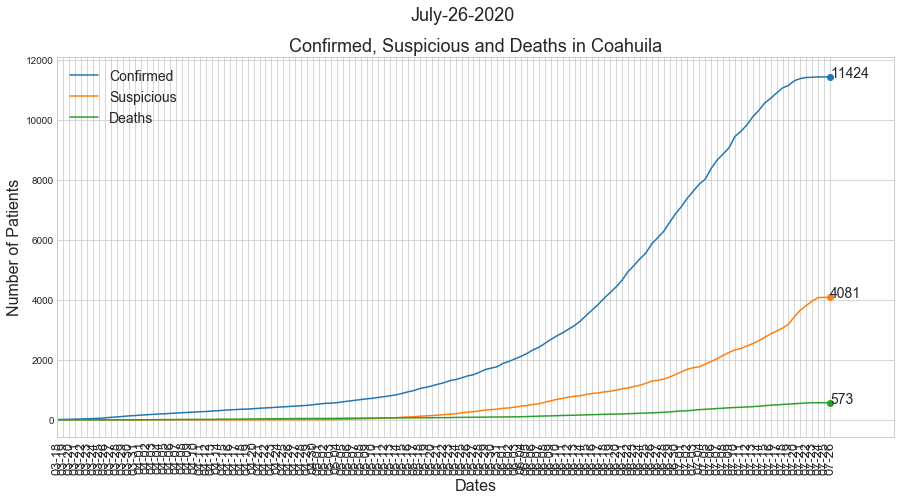

In [69]:
coahuila_confirmed = Covid('COAHUILA').cummulative('confirmed')
coahuila_suspicious= Covid('COAHUILA').cummulative('suspicious')
coahuila_deaths    = Covid('COAHUILA').cummulative('deaths')
Covid.plot_cummulative(data = [coahuila_confirmed,
                               coahuila_suspicious,
                               coahuila_deaths],
                    names = ['Confirmed','Suspicious','Deaths'],
                    trim = 70,
                    title = 'Confirmed, Suspicious and Deaths in Coahuila')

### Actives

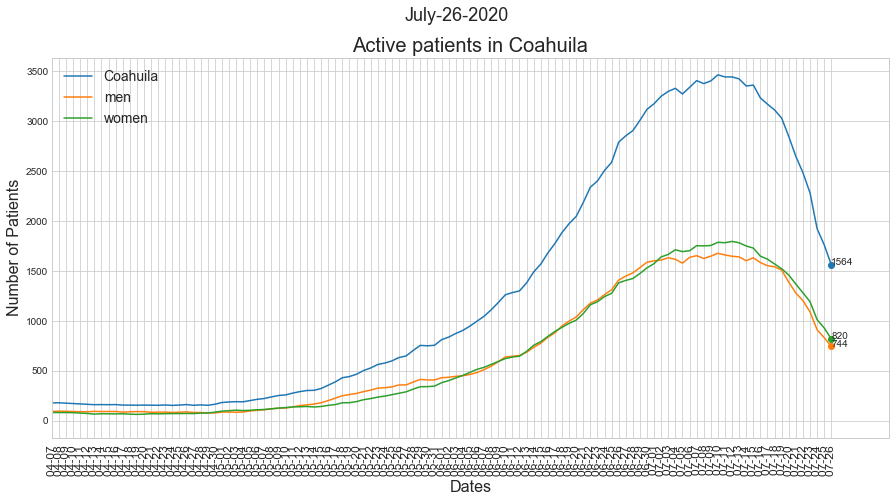

In [70]:
coahuila_active   = Covid('COAHUILA').patients().actives()

coahuila_men_active   = Covid('COAHUILA').patients().men().actives()
coahuila_women_active = Covid('COAHUILA').patients().women().actives()

Covid.plot_actives(data  = [coahuila_active,
                            coahuila_men_active,
                            coahuila_women_active],
                   names = ['Coahuila','men','women'],
                   trim = 40,
                   title = 'Active patients in Coahuila')

# Morelos

### Confirmed, Suspicious and Deaths

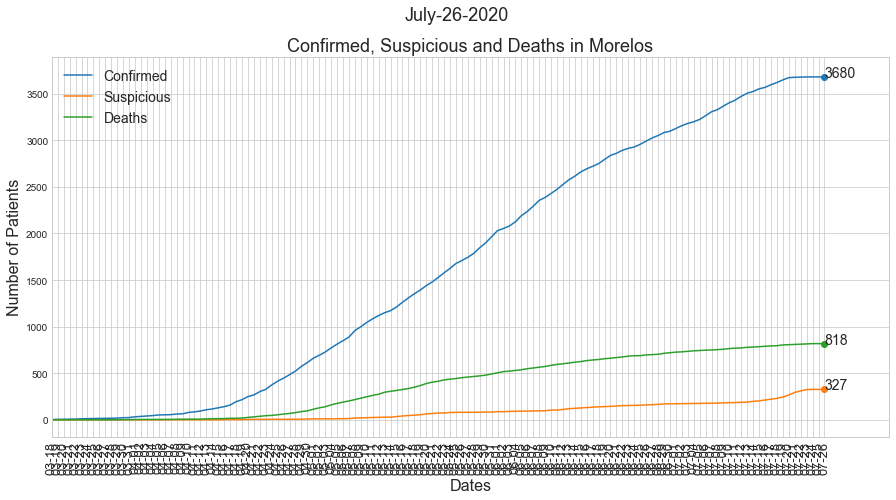

In [71]:
morelos_confirmed = Covid('MORELOS').cummulative('confirmed')
morelos_suspicious= Covid('MORELOS').cummulative('suspicious')
morelos_deaths    = Covid('MORELOS').cummulative('deaths')
Covid.plot_cummulative(data = [morelos_confirmed,
                               morelos_suspicious,
                               morelos_deaths],
                    names = ['Confirmed','Suspicious','Deaths'],
                    trim = 70,
                    title = 'Confirmed, Suspicious and Deaths in Morelos')

### Actives

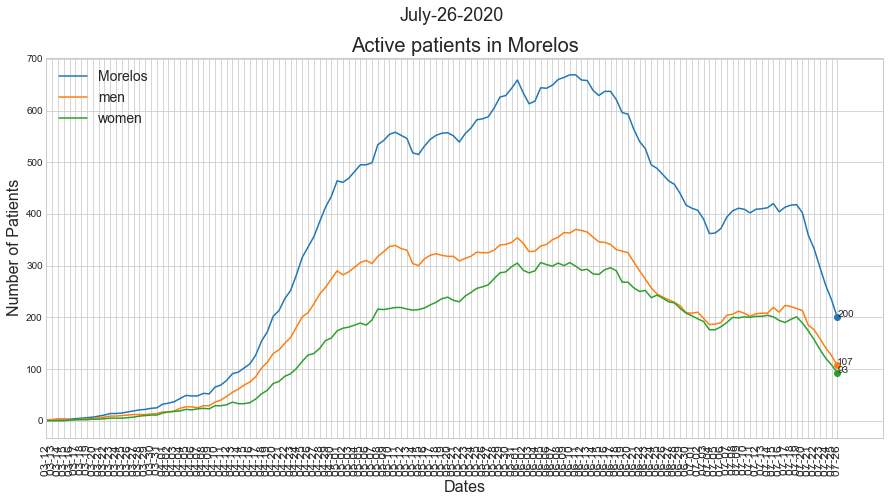

In [72]:
morelos_active   = Covid('MORELOS').patients().actives()

morelos_men_active   = Covid('MORELOS').patients().men().actives()
morelos_women_active = Covid('MORELOS').patients().women().actives()

Covid.plot_actives(data  = [morelos_active,
                            morelos_men_active,
                            morelos_women_active],
                   names = ['Morelos','men','women'],
                   trim = 10,
                   title = 'Active patients in Morelos')

# Queretaro

### Confirmed, Suspicious and Deaths

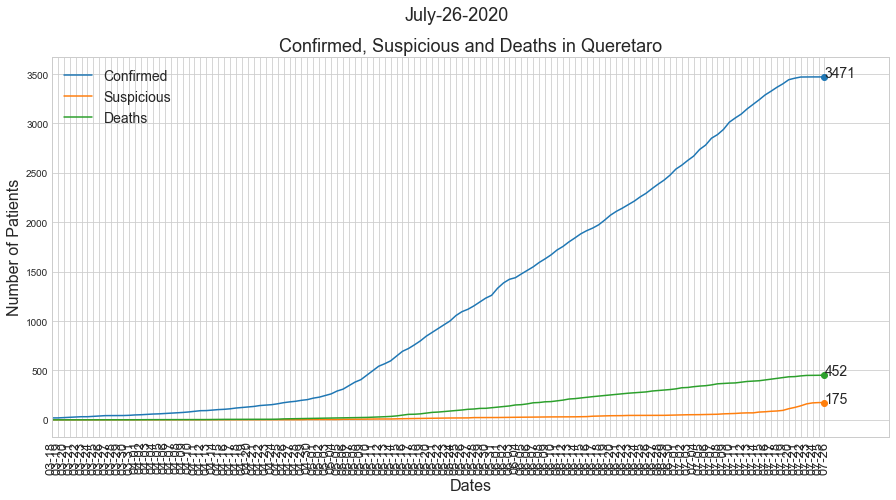

In [73]:
queretaro_confirmed = Covid('QUERETARO').cummulative('confirmed')
queretaro_suspicious= Covid('QUERETARO').cummulative('suspicious')
queretaro_deaths    = Covid('QUERETARO').cummulative('deaths')
Covid.plot_cummulative(data = [queretaro_confirmed,
                               queretaro_suspicious,
                               queretaro_deaths],
                    names = ['Confirmed','Suspicious','Deaths'],
                    trim = 70,
                    title = 'Confirmed, Suspicious and Deaths in Queretaro')

### Active

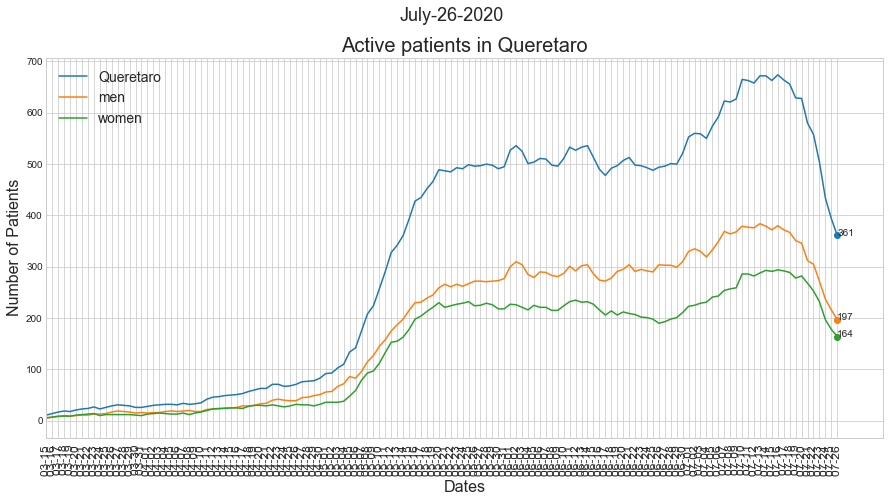

In [74]:
queretaro_active   = Covid('QUERETARO').patients().actives()

queretaro_men_active   = Covid('QUERETARO').patients().men().actives()
queretaro_women_active = Covid('QUERETARO').patients().women().actives()

Covid.plot_actives(data  = [queretaro_active,
                            queretaro_men_active,
                            queretaro_women_active],
                   names = ['Queretaro','men','women'],
                   trim = 10,
                   title = 'Active patients in Queretaro')

# Tlaxcala

### Confirmed, Suspicious and Deaths

In [75]:
tlaxcala_confirmed = Covid('TLAXCALA').cummulative('confirmed')
tlaxcala_suspicious= Covid('TLAXCALA').cummulative('suspicious')
tlaxcala_deaths    = Covid('TLAXCALA').cummulative('deaths')
Covid.plot_cummulative(data = [tlaxcala_confirmed,
                               tlaxcala_suspicious,
                               tlaxcala_deaths],
                    names = ['Confirmed','Suspicious','Deaths'],
                    trim = 70,
                    title = 'Confirmed, Suspicious and Deaths in Tlaxcala')

### Actives

In [76]:
tlaxcala_active   = Covid('TLAXCALA').patients().actives()

tlaxcala_men_active   = Covid('TLAXCALA').patients().men().actives()
tlaxcala_women_active = Covid('TLAXCALA').patients().women().actives()

Covid.plot_actives(data  = [tlaxcala_active,
                            tlaxcala_men_active,
                            tlaxcala_women_active],
                   names = ['Tlaxcala','men','women'],
                   trim = 10,
                   title = 'Active patients in Tlaxcala')

# Durango

### Confirmed, Suspicious and Deaths

In [77]:
durango_confirmed = Covid('DURANGO').cummulative('confirmed')
durango_suspicious= Covid('DURANGO').cummulative('suspicious')
durango_deaths    = Covid('DURANGO').cummulative('deaths')
Covid.plot_cummulative(data = [durango_confirmed,
                               durango_suspicious,
                               durango_deaths],
                    names = ['Confirmed','Suspicious','Deaths'],
                    trim = 70,
                    title = 'Confirmed, Suspicious and Deaths in Durango')

### Actives

In [78]:
durango_active       = Covid('DURANGO').patients().actives()

durango_men_active   = Covid('DURANGO').patients().men().actives()
durango_women_active = Covid('DURANGO').patients().women().actives()

Covid.plot_actives(data  = [durango_active,
                            durango_men_active,
                            durango_women_active],
                   names = ['Durango','men','women'],
                   trim = 10,
                   title = 'Active patients in Durango')

# Nayarit

### Confirmed, Suspicious and Deaths

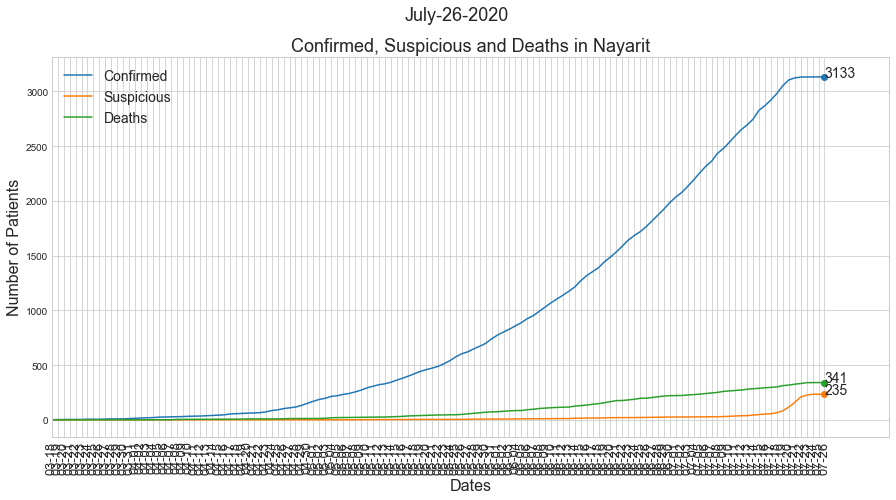

In [79]:
nayarit_confirmed = Covid('NAYARIT').cummulative('confirmed')
nayarit_suspicious= Covid('NAYARIT').cummulative('suspicious')
nayarit_deaths    = Covid('NAYARIT').cummulative('deaths')
Covid.plot_cummulative(data = [nayarit_confirmed,
                               nayarit_suspicious,
                               nayarit_deaths],
                    names = ['Confirmed','Suspicious','Deaths'],
                    trim = 70,
                    title = 'Confirmed, Suspicious and Deaths in Nayarit')

### Actives

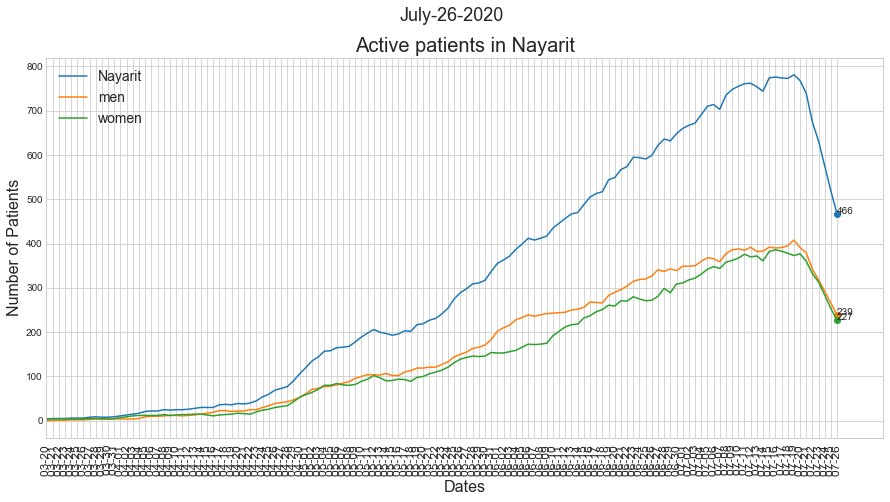

In [80]:
nayarit_active   = Covid('NAYARIT').patients().actives()

nayarit_men_active   = Covid('NAYARIT').patients().men().actives()
nayarit_women_active = Covid('NAYARIT').patients().women().actives()

Covid.plot_actives(data  = [nayarit_active,
                            nayarit_men_active,
                            nayarit_women_active],
                   names = ['Nayarit','men','women'],
                   trim = 10,
                   title = 'Active patients in Nayarit')

# Guerrero

### Confirmed, Suspicious and Deaths

In [81]:
guerrero_confirmed = Covid('GUERRERO').cummulative('confirmed')
guerrero_suspicious= Covid('GUERRERO').cummulative('suspicious')
guerrero_deaths    = Covid('GUERRERO').cummulative('deaths')
Covid.plot_cummulative(data = [guerrero_confirmed,
                               guerrero_suspicious,
                               guerrero_deaths],
                    names = ['Confirmed','Suspicious','Deaths'],
                    trim = 70,
                    title = 'Confirmed, Suspicious and Deaths in Guerrero')

### Actives

In [82]:
guerrero_active   = Covid('GUERRERO').patients().actives()

guerrero_men_active   = Covid('GUERRERO').patients().men().actives()
guerrero_women_active = Covid('GUERRERO').patients().women().actives()

Covid.plot_actives(data  = [guerrero_active,
                            guerrero_men_active,
                            guerrero_women_active],
                   names = ['Guerrero','men','women'],
                   trim = 20,
                   title = 'Active patients in Guerrero')

# Campeche

### Confirmed, Suspicious and Deaths

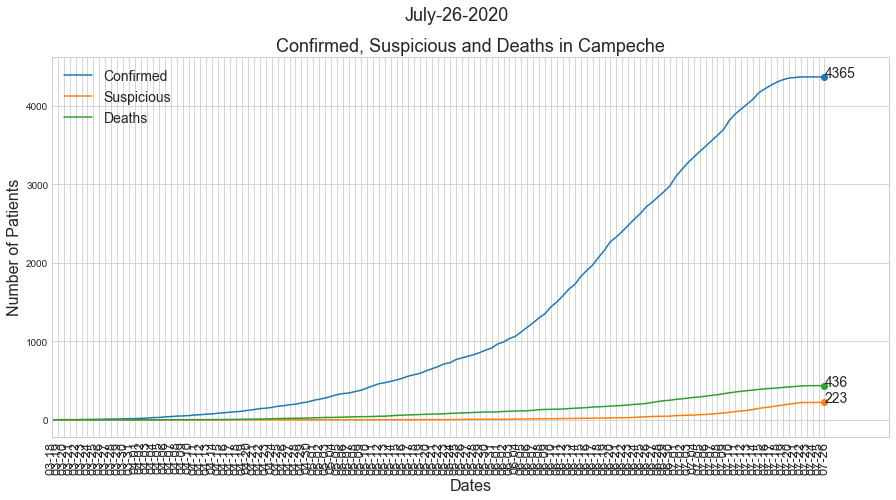

In [83]:
campeche_confirmed = Covid('CAMPECHE').cummulative('confirmed')
campeche_suspicious= Covid('CAMPECHE').cummulative('suspicious')
campeche_deaths    = Covid('CAMPECHE').cummulative('deaths')
Covid.plot_cummulative(data = [campeche_confirmed,
                               campeche_suspicious,
                               campeche_deaths],
                    names = ['Confirmed','Suspicious','Deaths'],
                    trim = 70,
                    title = 'Confirmed, Suspicious and Deaths in Campeche')

### Actives

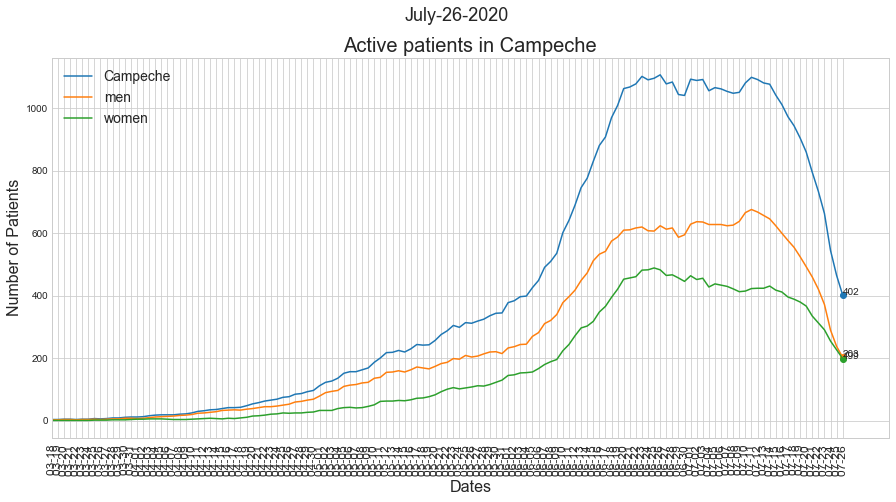

In [84]:
campeche_active   = Covid('CAMPECHE').patients().actives()

campeche_men_active   = Covid('CAMPECHE').patients().men().actives()
campeche_women_active = Covid('CAMPECHE').patients().women().actives()

Covid.plot_actives(data  = [campeche_active,
                            campeche_men_active,
                            campeche_women_active],
                   names = ['Campeche','men','women'],
                   trim = 10,
                   title = 'Active patients in Campeche')

# Baja California Sur

### Confirmed, Suspicious and Deaths

In [85]:
bcalifornia_sur_confirmed = Covid('BAJA CALIFORNIA SUR').cummulative('confirmed')
bcalifornia_sur_suspicious= Covid('BAJA CALIFORNIA SUR').cummulative('suspicious')
bcalifornia_sur_deaths    = Covid('BAJA CALIFORNIA SUR').cummulative('deaths')
Covid.plot_cummulative(data = [bcalifornia_sur_confirmed,
                               bcalifornia_sur_suspicious,
                               bcalifornia_sur_deaths],
                    names = ['Confirmed','Suspicious','Deaths'],
                    trim = 70,
                    title = 'Confirmed, Suspicious and Deaths in Baja California Sur')

### Actives

In [86]:
bcalifornia_sur_active   = Covid('BAJA CALIFORNIA SUR').patients().actives()

bcalifornia_sur_men_active   = Covid('BAJA CALIFORNIA SUR').patients().men().actives()
bcalifornia_sur_women_active = Covid('BAJA CALIFORNIA SUR').patients().women().actives()

Covid.plot_actives(data  = [bcalifornia_sur_active,
                            bcalifornia_sur_men_active,
                            bcalifornia_sur_women_active],
                   names = ['Baja California Sur','men','women'],
                   trim = 5,
                   title = 'Active patients in Baja California Sur')

# Chihuahua

### Confirmed, Suspicious and Deaths

In [87]:
chihuahua_confirmed = Covid('CHIHUAHUA').cummulative('confirmed')
chihuahua_suspicious= Covid('CHIHUAHUA').cummulative('suspicious')
chihuahua_deaths    = Covid('CHIHUAHUA').cummulative('deaths')
Covid.plot_cummulative(data = [chihuahua_confirmed,
                               chihuahua_suspicious,
                               chihuahua_deaths],
                    names = ['Confirmed','Suspicious','Deaths'],
                    trim = 70,
                    title = 'Confirmed, Suspicious and Deaths in Chihuahua')

### Active

In [88]:
chihuahua_active   = Covid('CHIHUAHUA').patients().actives()

chihuahua_men_active   = Covid('CHIHUAHUA').patients().men().actives()
chihuahua_women_active = Covid('CHIHUAHUA').patients().women().actives()

Covid.plot_actives(data  = [chihuahua_active,
                            chihuahua_men_active,
                            chihuahua_women_active],
                   names = ['Chihuahua','men','women'],
                   trim = 10,
                   title = 'Active patients in Chihuahua')

# Zacatecas

### Confirmed, Suspicious and Deaths

In [89]:
zacatecas_confirmed = Covid('ZACATECAS').cummulative('confirmed')
zacatecas_suspicious= Covid('ZACATECAS').cummulative('suspicious')
zacatecas_deaths    = Covid('ZACATECAS').cummulative('deaths')
Covid.plot_cummulative(data = [zacatecas_confirmed,
                               zacatecas_suspicious,
                               zacatecas_deaths],
                    names = ['Confirmed','Suspicious','Deaths'],
                    trim = 70,
                    title = 'Confirmed, Suspicious and Deaths in Zacatecas')

### Actives

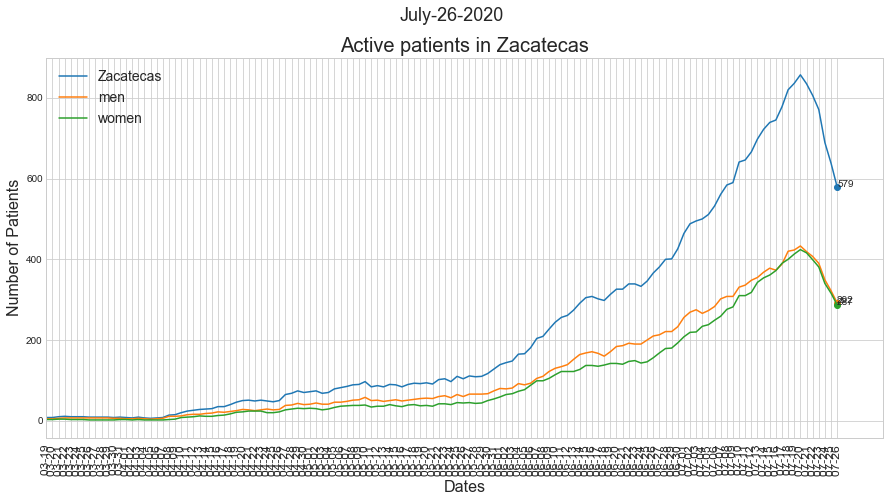

In [90]:
zacatecas_active   = Covid('ZACATECAS').patients().actives()

zacatecas_men_active   = Covid('ZACATECAS').patients().men().actives()
zacatecas_women_active = Covid('ZACATECAS').patients().women().actives()

Covid.plot_actives(data  = [zacatecas_active,
                            zacatecas_men_active,
                            zacatecas_women_active],
                   names = ['Zacatecas','men','women'],
                   trim = 10,
                   title = 'Active patients in Zacatecas')

# Colima

### Confirmed, Suspicious and Deaths

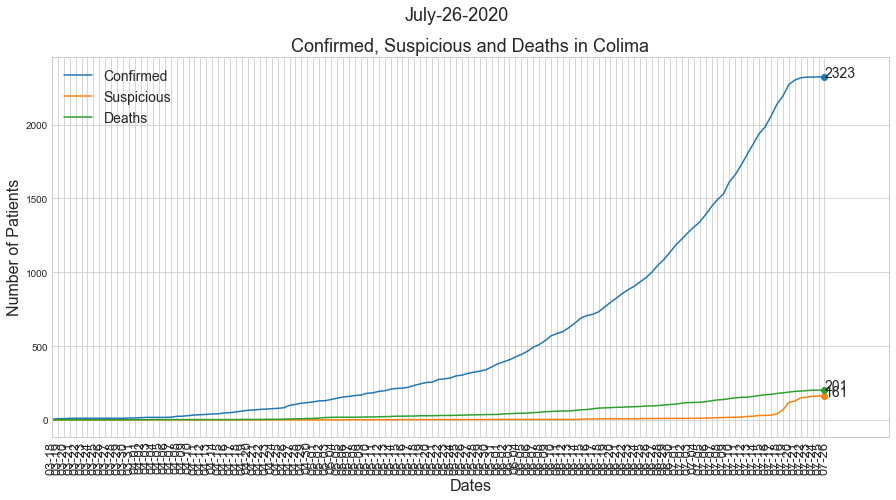

In [91]:
colima_confirmed = Covid('COLIMA').cummulative('confirmed')
colima_suspicious= Covid('COLIMA').cummulative('suspicious')
colima_deaths    = Covid('COLIMA').cummulative('deaths')
Covid.plot_cummulative(data = [zacatecas_confirmed,
                               zacatecas_suspicious,
                               zacatecas_deaths],
                    names = ['Confirmed','Suspicious','Deaths'],
                    trim = 70,
                    title = 'Confirmed, Suspicious and Deaths in Colima')

### Actives

In [92]:
colima_active   = Covid('COLIMA').patients().actives()

colima_men_active   = Covid('COLIMA').patients().men().actives()
colima_women_active = Covid('COLIMA').patients().women().actives()

Covid.plot_actives(data  = [colima_active,
                            colima_men_active,
                            colima_women_active],
                   names = ['Colima','men','women'],
                   trim = 10,
                   title = 'Active patients in Colima')